In [4]:
import pandas as pd
import numpy
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("..")
from utils import pad_collate
from dataloader_comma import CommaDataset
from dataloader_nuscenes import NUScenesDataset
from collections import Counter
import imageio
from model import VTN
import matplotlib.pyplot as plt
from PIL import Image
import glob
from scipy.stats import pearsonr
plt.rcParams.update({'font.size': 18}) 
import os
from utils import * 
import re
from vis_utils import * 
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


In [5]:
ckpt = torch.load(checkpoint_path, map_location=gpu)
state_dict = ckpt['state_dict']
state_dict = get_regular_ckpt_from_lightning_checkpoint(state_dict)
model.load_state_dict(state_dict)
model.eval()
model = model.to(gpu)

In [6]:
def split_string(string):
    words = string.split()#.replace("a photo of driving on a highway with", "").replace("a photo of", "").replace("driving on a highway", "").replace("past", "").replace("a street with", "").split()  # Split the string into a list of words
    result = []
    current_line = ""
    
    for word in words:
        if len(current_line) + len(word) <= 40:
            current_line += word + " "
        else:
            result.append(current_line.strip())
            current_line = word + " "
    
    if current_line:
        result.append(current_line.strip())
    
    return "\n".join(result)

In [11]:
#for j, batch in enumerate(dataloader_nuscenes):
#    _, image_array,  vego, angle, distance, _, _, _, _, _ = batch
for j, batch in enumerate(dataloader_comma):
    if j != 0: continue
    image_array,  vego, angle, distance, g, s, l = batch
    img = image_array
    max_len = 240
    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    (logits, attns), concepts = model(img, angle, distance, vego)
    top5_indices_res = torch.tensor(concepts.squeeze()).topk(10)
    top5_indices = top5_indices_res.indices
    s = img.shape
    angle, distance, vego, logits, concepts = angle.to("cpu"), distance.to("cpu"), vego.to("cpu"), logits.detach().cpu().to("cpu"), concepts.detach().cpu().to("cpu")

    atten = attns[2][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_2 = alignment_array.sum(axis=0)[8:-8]
    #speed_graph_2 = moving_average(speed_graph_2, 10)

    atten = attns[0][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_0 = alignment_array.sum(axis=0)[8:-8]
    #speed_graph_0 = moving_average(speed_graph_0, 10)

    atten = attns[1][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_1 = alignment_array.sum(axis=0)[8:-8]
    #speed_graph_1 = moving_average(speed_graph_1, 10)

    
    f = []
    inter = []
    
    for i, elem0 in enumerate(top5_indices):
        #print(top5_indices_res.values[i])
        #print(elem0)
        inter = []
        for elem in top5_indices[max(i-2, 0):min(i+2,len(top5_indices))]:
            l = elem.cpu().numpy().tolist()
            if 131 in l:
                l.remove(131)
            if 55 in l:
                l.remove(55)
            if 14 in l:
                l.remove(14)
            if 17 in l:
                l.remove(17)
            inter.extend(l)
        count_dict = Counter(inter)
        # Get the top 5 most occurring numbers
        top_5 = count_dict.most_common(3)
        intermediate = []
        for a in top_5: 
            intermediate.append(scenarios[a[0]])
        #print(intermediate)
        f.append(intermediate)
    
    #fig, axes = plt.subplots(1, 1, figsize=(12, 16))#,gridspec_kw= {'height_ratios': [20, 1]})
    
    plt_idx = 0
    for i, image in tqdm(enumerate(img[0][0:])):
        fig, axes = plt.subplots(2, 1, figsize=(8, 16),gridspec_kw= {'height_ratios': [2, 1]})
    
        image_frame = (image).cpu().permute(1, 2, 0)

        axes[0].imshow((np.array(image_frame) * 255).astype(np.uint8))
        
        title = '\n'.join([split_string("\u2022 " + h) for h in f[i]])
        axes[0].set_title(title)
        axes[0].set_aspect('equal')
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        # Remove borders
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['bottom'].set_visible(False)
        axes[0].spines['left'].set_visible(False)
        axes[0].spines['right'].set_visible(False)

        # Plot the speed graph
        axes[1].plot(speed_graph_2, label='Attention', color='black')
        axes[1].plot(speed_graph_1, label='Attention', color='red')
        axes[1].plot(speed_graph_0, label='Attention', color='green')
    

        axes[1].set_xlabel('Time Step')

        axes[1].plot(i, speed_graph_2[i], marker='o', markersize=10, color='black')
        axes[1].plot(i, speed_graph_0[i], marker='o', markersize=10, color='green')
        axes[1].plot(i, speed_graph_1[i], marker='o', markersize=10, color='red')
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)
    
        plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/mturk/{i}.png")
        plt.close()

    
    image_directory = '/home/jessica/personalized_driving_toyota/result_images/mturk/'

    # Set the output GIF file path
    output_path = lambda x: f'/home/jessica/personalized_driving_toyota/result_images/mturk/att/w_attention_nusc_{j}_{x}.mp4'

    # Set the duration (in milliseconds) for each frame in the GIF
    frame_duration = 8000

    # Get a sorted list of image files in the directory
    image_files = sorted(glob.glob(f'{image_directory}/*.png'), key=extract_number)  # Adjust the file extension if necessary

    # Create a list to store the frames of the GIF
    frames = []

    # Iterate over each image file
    for image_file in image_files:
        # Open the image file
        image = Image.open(image_file)

        # Add the image to the list of frames
        frames.append(image)

    # Save the frames as a GIF
    frames[0].save(f'/home/jessica/personalized_driving_toyota/result_images/mturk/att/w_attention_nusc_{j}.gif', format='GIF', append_images=frames[1:], save_all=True,
               duration=frame_duration, loop=0)
    imageio.mimsave(output_path("2"), frames, fps=1)
    #imageio.mimsave(output_path("1"), frames[40:56], fps=2)

    directory = '/home/jessica/personalized_driving_toyota/result_images/mturk'
    '''for filename in os.listdir(directory):
        if filename.endswith('.png'):
            file_path = os.path.join(directory, filename)
            os.remove(file_path)'''
    if j > 50: break

20it [00:04,  4.13it/s]
[rawvideo @ 0x6879680] Stream #0: not enough frames to estimate rate; consider increasing probesize
20it [00:05,  3.63it/s]
[rawvideo @ 0x673d680] Stream #0: not enough frames to estimate rate; consider increasing probesize
20it [00:05,  3.49it/s]
[rawvideo @ 0x578a680] Stream #0: not enough frames to estimate rate; consider increasing probesize
20it [00:04,  4.08it/s]
[rawvideo @ 0x570d680] Stream #0: not enough frames to estimate rate; consider increasing probesize
20it [00:05,  3.94it/s]
[rawvideo @ 0x70d9680] Stream #0: not enough frames to estimate rate; consider increasing probesize
20it [00:05,  3.51it/s]
[rawvideo @ 0x73ae680] Stream #0: not enough frames to estimate rate; consider increasing probesize
20it [00:05,  3.74it/s]
[rawvideo @ 0x6e02680] Stream #0: not enough frames to estimate rate; consider increasing probesize
20it [00:04,  4.02it/s]
[rawvideo @ 0x6f5e680] Stream #0: not enough frames to estimate rate; consider increasing probesize
20it [00

8it [00:02,  4.07it/s]

In [28]:

sg1 = []
sg2 = []
sg3 = []
angles = []
dists = []
vegs = []
for j, batch in enumerate(dataloader_comma):
    image_array,  vego, angle, distance, g, s, l = batch
    img = image_array
    max_len = 240
    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    (logits, attns), concepts = model(img, angle, distance, vego)
    top5_indices_res = torch.tensor(concepts.squeeze()).topk(10)
    top5_indices = top5_indices_res.indices
    s = img.shape
    angle, distance, vego, logits, concepts = angle.to("cpu")[:, 10:-10], distance.to("cpu")[:, 10:-10], vego.to("cpu")[:, 10:-10], logits.detach().cpu().to("cpu"), concepts.detach().cpu().to("cpu")

    atten = attns[2][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_2 = alignment_array.sum(axis=0)[8:-8]
    
    speed_graph_2 = moving_average(speed_graph_2, 10)[10:-10]

    atten = attns[0][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_0 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_0 = moving_average(speed_graph_0, 10)[10:-10]

    atten = attns[1][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_1 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_1 = moving_average(speed_graph_1, 10)[10:-10]
    print(len(speed_graph_1), angle.shape)
    sg1.extend(speed_graph_0)
    sg2.extend(speed_graph_1)
    sg3.extend(speed_graph_2)
    dists.extend(distance.squeeze().tolist())
    vegs.extend(vego.squeeze().tolist())
    angles.extend(angle.squeeze().tolist())


    continue
    
    f = []
    inter = []
    
    for i, elem0 in enumerate(top5_indices):
        #print(top5_indices_res.values[i])
        #print(elem0)
        inter = []
        for elem in top5_indices[max(i-2, 0):min(i+2,len(top5_indices))]:
            l = elem.cpu().numpy().tolist()
            if 131 in l:
                l.remove(131)
            if 55 in l:
                l.remove(55)
            if 14 in l:
                l.remove(14)
            if 17 in l:
                l.remove(17)
            inter.extend(l)
        count_dict = Counter(inter)
        # Get the top 5 most occurring numbers
        top_5 = count_dict.most_common(3)
        intermediate = []
        for a in top_5: 
            intermediate.append(scenarios[a[0]])
        #print(intermediate)
        f.append(intermediate)
    
    #fig, axes = plt.subplots(1, 1, figsize=(12, 16))#,gridspec_kw= {'height_ratios': [20, 1]})
    
    plt_idx = 0
    for i, image in tqdm(enumerate(img[0][0:])):
        fig, axes = plt.subplots(2, 1, figsize=(8, 16),gridspec_kw= {'height_ratios': [2, 1]})
    
        image_frame = (image).cpu().permute(1, 2, 0)

        axes[0].imshow((np.array(image_frame) * 255).astype(np.uint8))
        
        title = '\n'.join([split_string("\u2022 " + h) for h in f[i]])
        axes[0].set_title(title)
        axes[0].set_aspect('equal')
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        # Remove borders
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['bottom'].set_visible(False)
        axes[0].spines['left'].set_visible(False)
        axes[0].spines['right'].set_visible(False)

        # Plot the speed graph
        axes[1].plot(speed_graph_2, label='Attention', color='black')
        axes[1].plot(speed_graph_1, label='Attention', color='red')
        axes[1].plot(speed_graph_0, label='Attention', color='green')
    

        axes[1].set_xlabel('Time Step')

        axes[1].plot(i, speed_graph_2[i], marker='o', markersize=10, color='black')
        axes[1].plot(i, speed_graph_0[i], marker='o', markersize=10, color='green')
        axes[1].plot(i, speed_graph_1[i], marker='o', markersize=10, color='red')
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)
    
        plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/mturk/{i}.png")
        plt.close()

    
    image_directory = '/home/jessica/personalized_driving_toyota/result_images/mturk/'

    # Set the output GIF file path
    output_path = lambda x: f'/home/jessica/personalized_driving_toyota/result_images/mturk/att/w_attention_comma_{j}_{x}.mp4'

    # Set the duration (in milliseconds) for each frame in the GIF
    frame_duration = 8000

    # Get a sorted list of image files in the directory
    image_files = sorted(glob.glob(f'{image_directory}/*.png'), key=extract_number)  # Adjust the file extension if necessary

    # Create a list to store the frames of the GIF
    frames = []

    # Iterate over each image file
    for image_file in image_files:
        # Open the image file
        image = Image.open(image_file)

        # Add the image to the list of frames
        frames.append(image)

    # Save the frames as a GIF
    #frames[0].save(output_path("gif"), format='GIF', append_images=frames[1:], save_all=True,
    #           duration=frame_duration, loop=0)
    imageio.mimsave(output_path("0"), frames, fps=1)
    #imageio.mimsave(output_path("1"), frames[40:56], fps=2)

    directory = '/home/jessica/personalized_driving_toyota/result_images/mturk'
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            file_path = os.path.join(directory, filename)
            os.remove(file_path)
    if j > 50: break

220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])
220 torch.Size([1, 220])


In [29]:
corr_coefficient12, p_value12 = pearsonr(sg1, angles)
corr_coefficient13, p_value13 = pearsonr(sg2, angles)
corr_coefficient11, p_value11 = pearsonr(sg3, angles)

corr_coefficient21, p_value21 = pearsonr(sg3, dists)
corr_coefficient22, p_value22 = pearsonr(sg1, dists)
corr_coefficient23, p_value23 = pearsonr(sg2, dists)

corr_coefficient31, p_value31 = pearsonr(sg1, vegs)
corr_coefficient32, p_value32 = pearsonr(sg2, vegs)
corr_coefficient33, p_value33 = pearsonr(sg3, vegs)

print(corr_coefficient12, p_value12)
print(corr_coefficient13, p_value13 )
print(corr_coefficient11, p_value11 )

print(corr_coefficient21, p_value21 )
print(corr_coefficient22, p_value22 )
print(corr_coefficient23, p_value23 )

print(corr_coefficient31, p_value31 )
print(corr_coefficient32, p_value32)
print(corr_coefficient33, p_value33)

-0.11245662977183236 6.029070773500336e-17
0.01610816052442187 0.23231406419367415
-0.13094566029056776 1.8267099944152882e-22
-0.19741664638210313 1.8803153058809944e-49
-0.15893872222839175 1.9099137983836918e-32
-0.013675870923779898 0.31056050771960253
-0.4757347445994345 1.009059313527404e-308
-0.012401697399036 0.35780231834691706
-0.20074420674243412 4.16853383069545e-51


In [22]:
len(angles), len(sg2)

(5500, 5000)

torch.Size([20, 10])


4it [00:00,  4.85it/s]

20it [00:07,  2.51it/s]
[rawvideo @ 0x708f680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.39it/s]
[rawvideo @ 0x619e680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.41it/s]
[rawvideo @ 0x60a2680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.31it/s]
[rawvideo @ 0x614c680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.25it/s]
[rawvideo @ 0x70ca680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.39it/s]
[rawvideo @ 0x6396680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:09,  2.09it/s]
[rawvideo @ 0x5f7d680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.43it/s]
[rawvideo @ 0x6b93680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.28it/s]
[rawvideo @ 0x6a58680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:09,  2.09it/s]
[rawvideo @ 0x57c6680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.28it/s]
[rawvideo @ 0x5a52680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.23it/s]
[rawvideo @ 0x67db680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.43it/s]
[rawvideo @ 0x6e31680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.30it/s]
[rawvideo @ 0x5faf680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.45it/s]
[rawvideo @ 0x6baa680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.46it/s]
[rawvideo @ 0x7381680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:09,  2.14it/s]
[rawvideo @ 0x71e9680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.35it/s]
[rawvideo @ 0x64ea680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.38it/s]
[rawvideo @ 0x5959680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:10,  2.00it/s]
[rawvideo @ 0x71b6680] Stream #0: not enough frames to estimate rate; consider increasing probesize
/tmp/ipykernel_624605/1750007306.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 1, figsize=(12, 16))#,gridspec_kw= {'height_ratios': [20, 1]})


torch.Size([20, 10])


20it [00:08,  2.44it/s]
[rawvideo @ 0x5632680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:08,  2.44it/s]
[rawvideo @ 0x7342680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:09,  2.13it/s]
[rawvideo @ 0x6ea3680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:07,  2.72it/s]
[rawvideo @ 0x5ba4680] Stream #0: not enough frames to estimate rate; consider increasing probesize


torch.Size([20, 10])


20it [00:06,  2.91it/s]
[rawvideo @ 0x6682680] Stream #0: not enough frames to estimate rate; consider increasing probesize


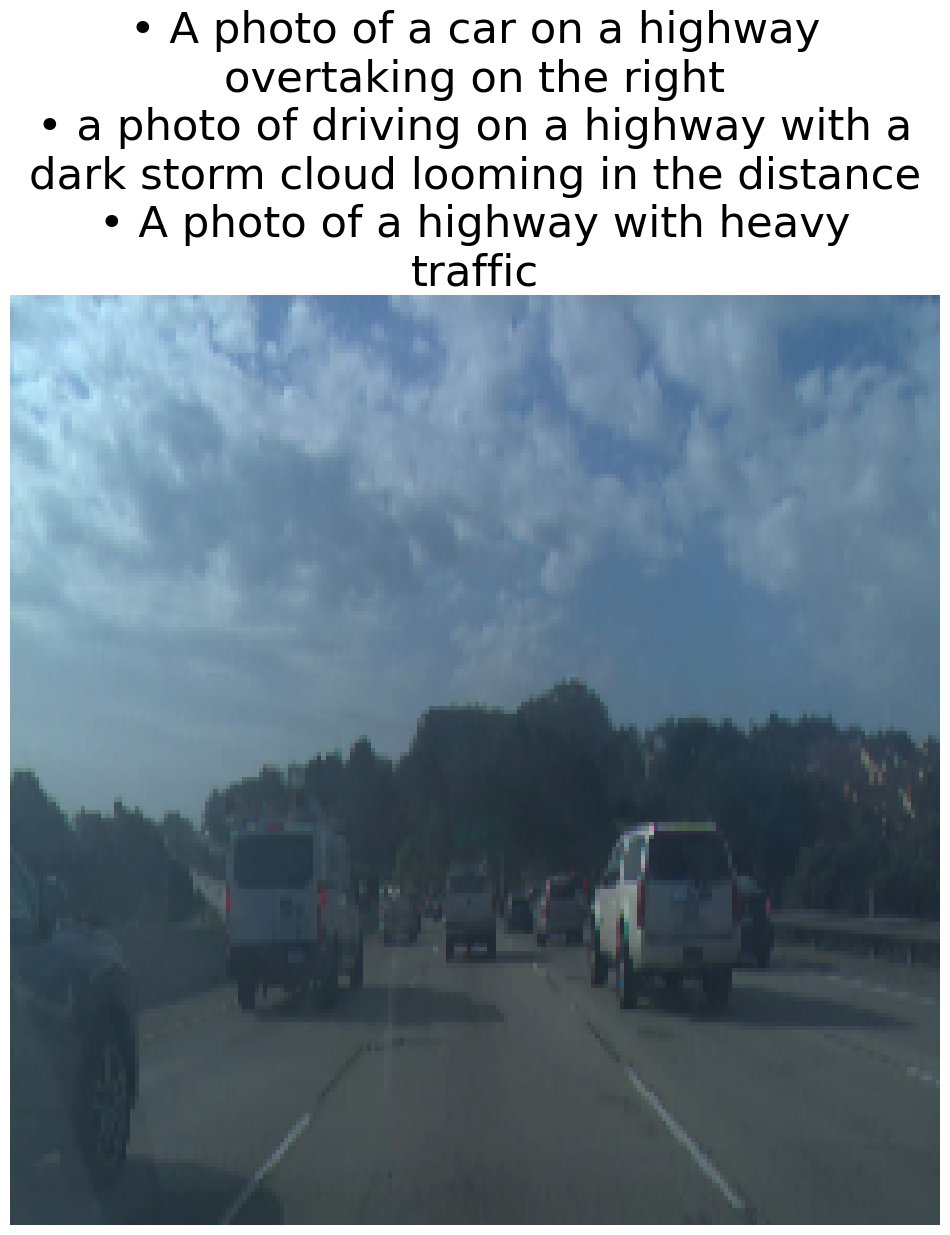

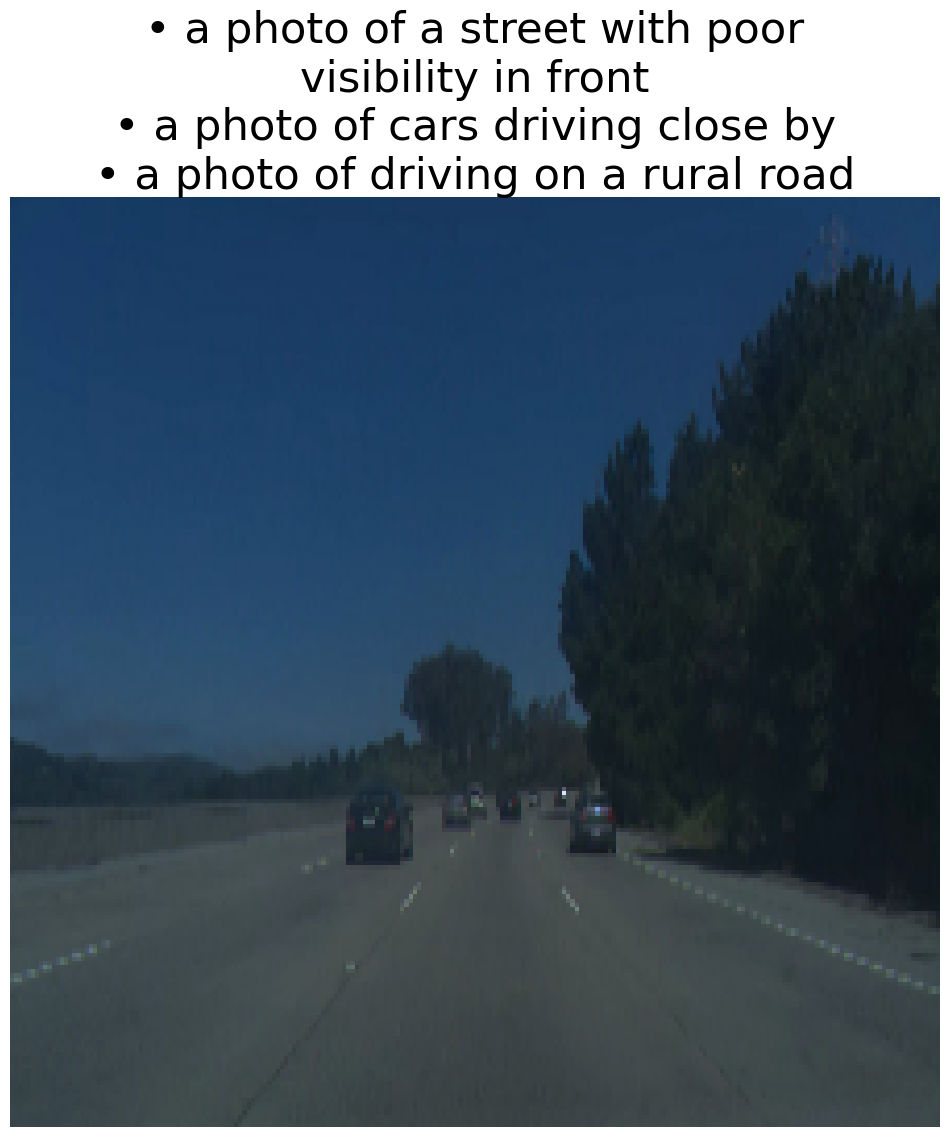

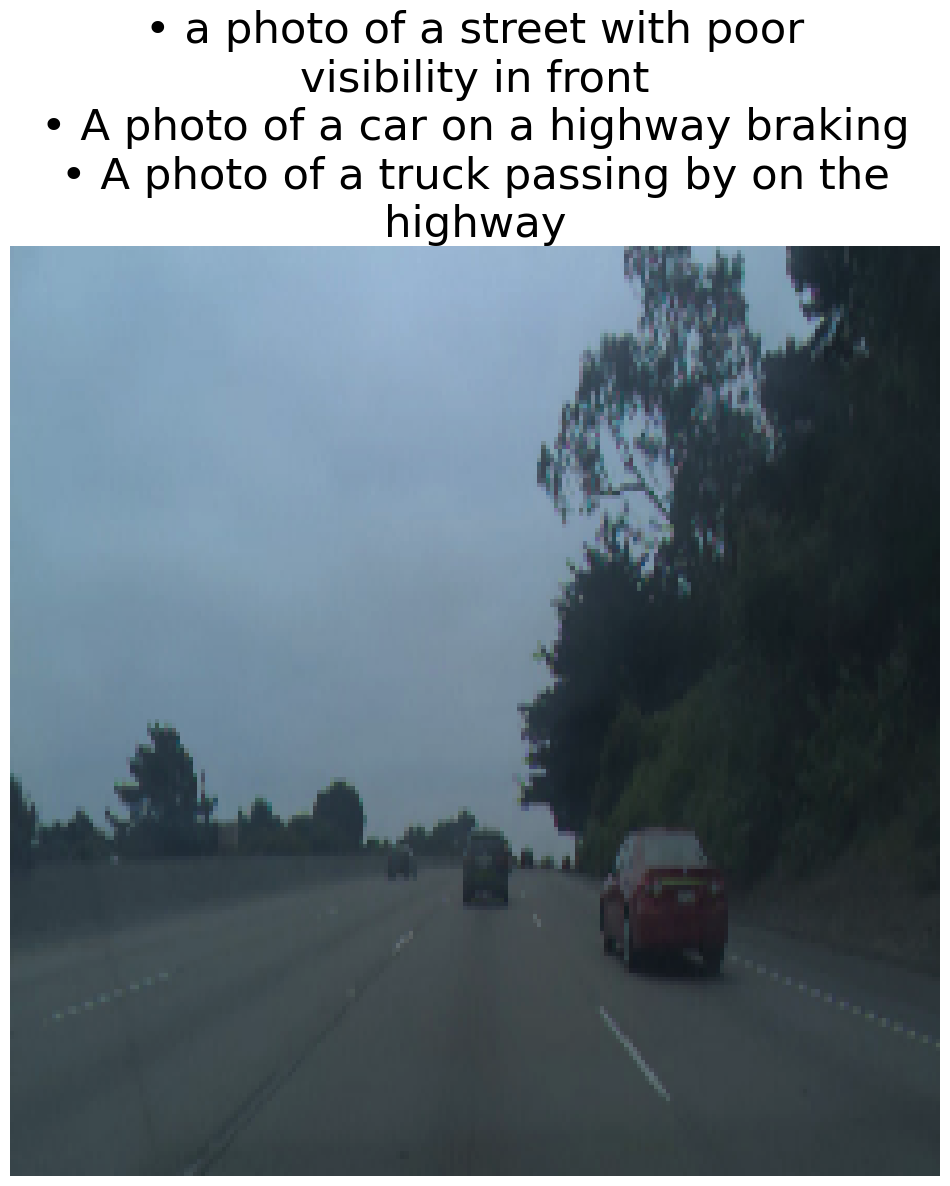

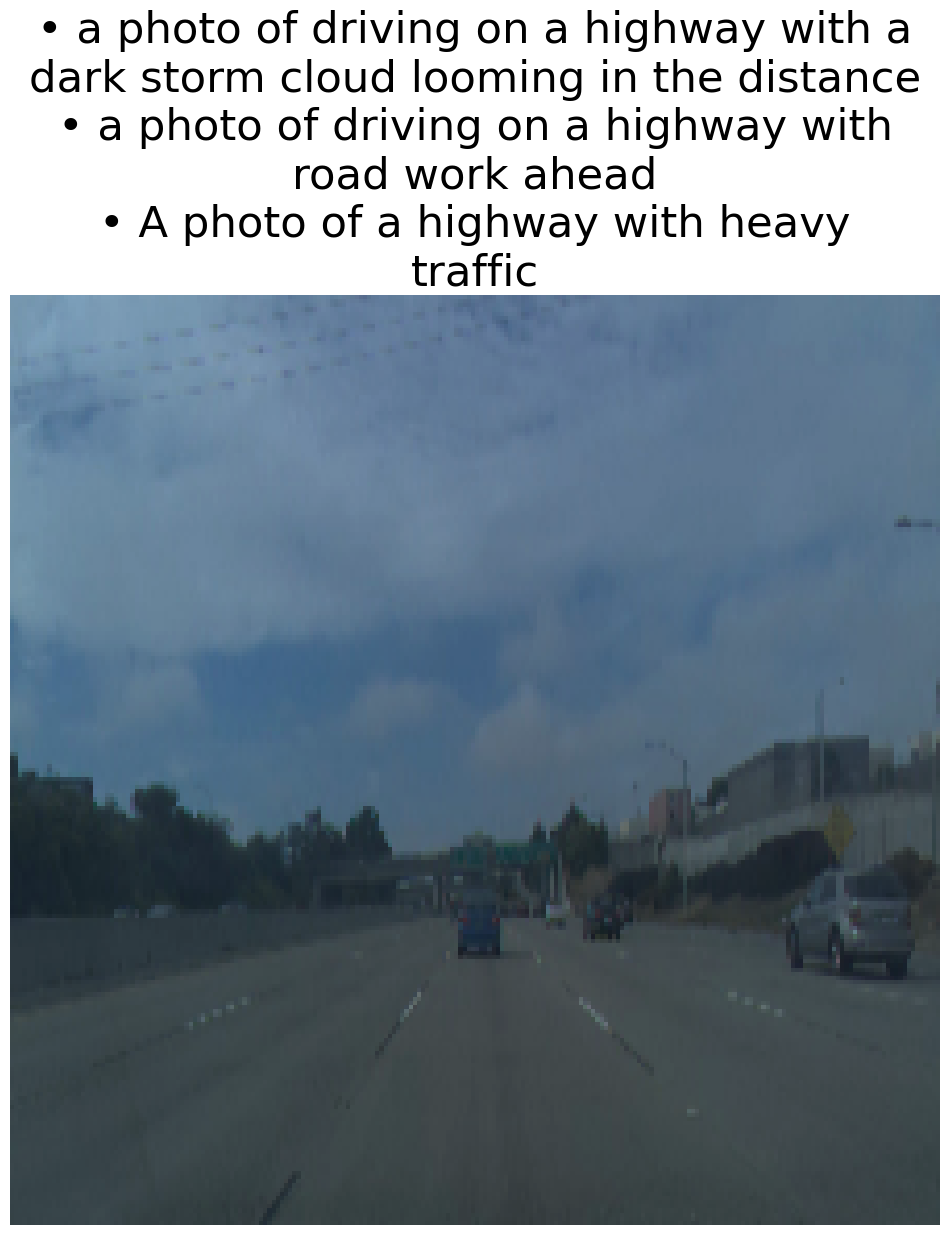

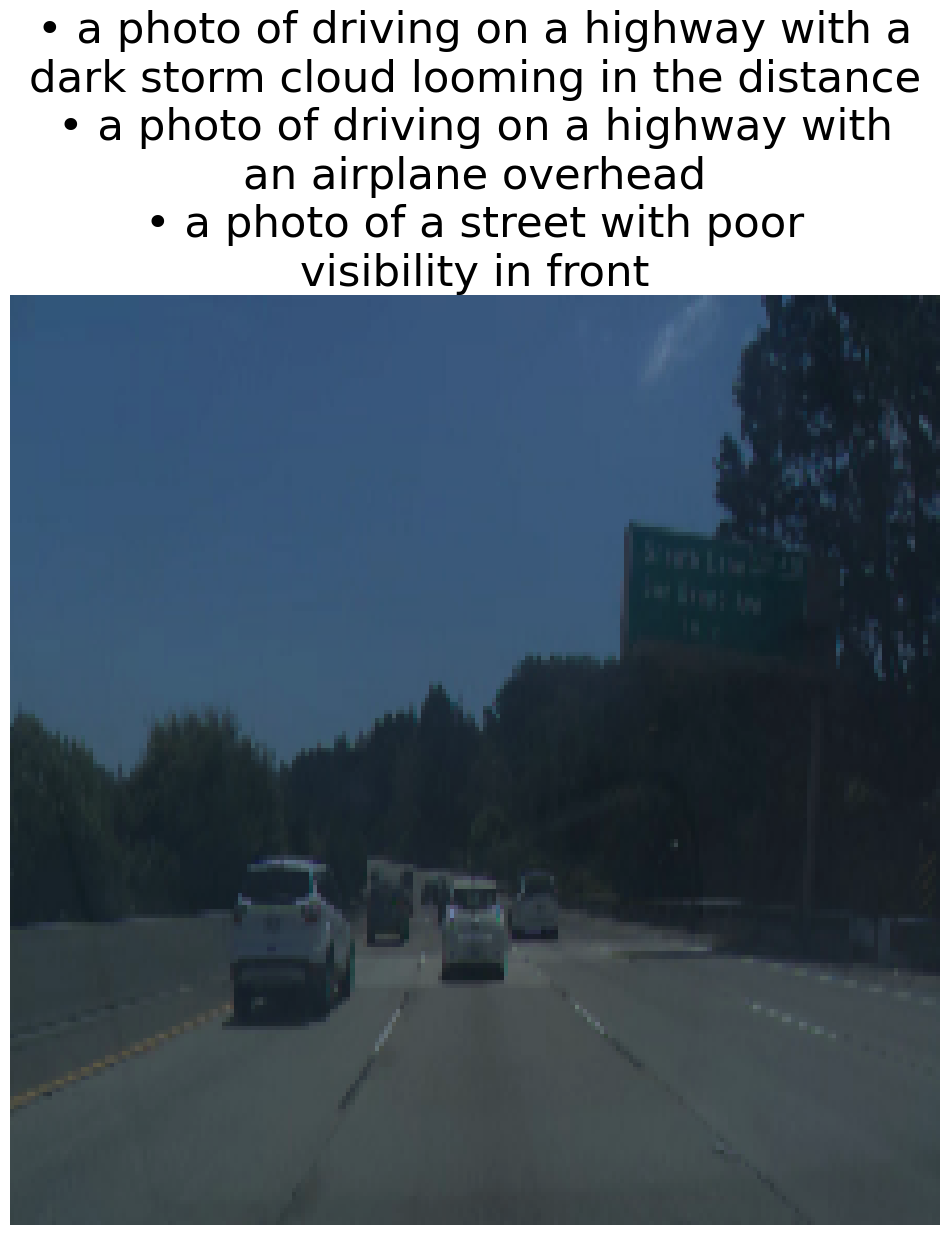

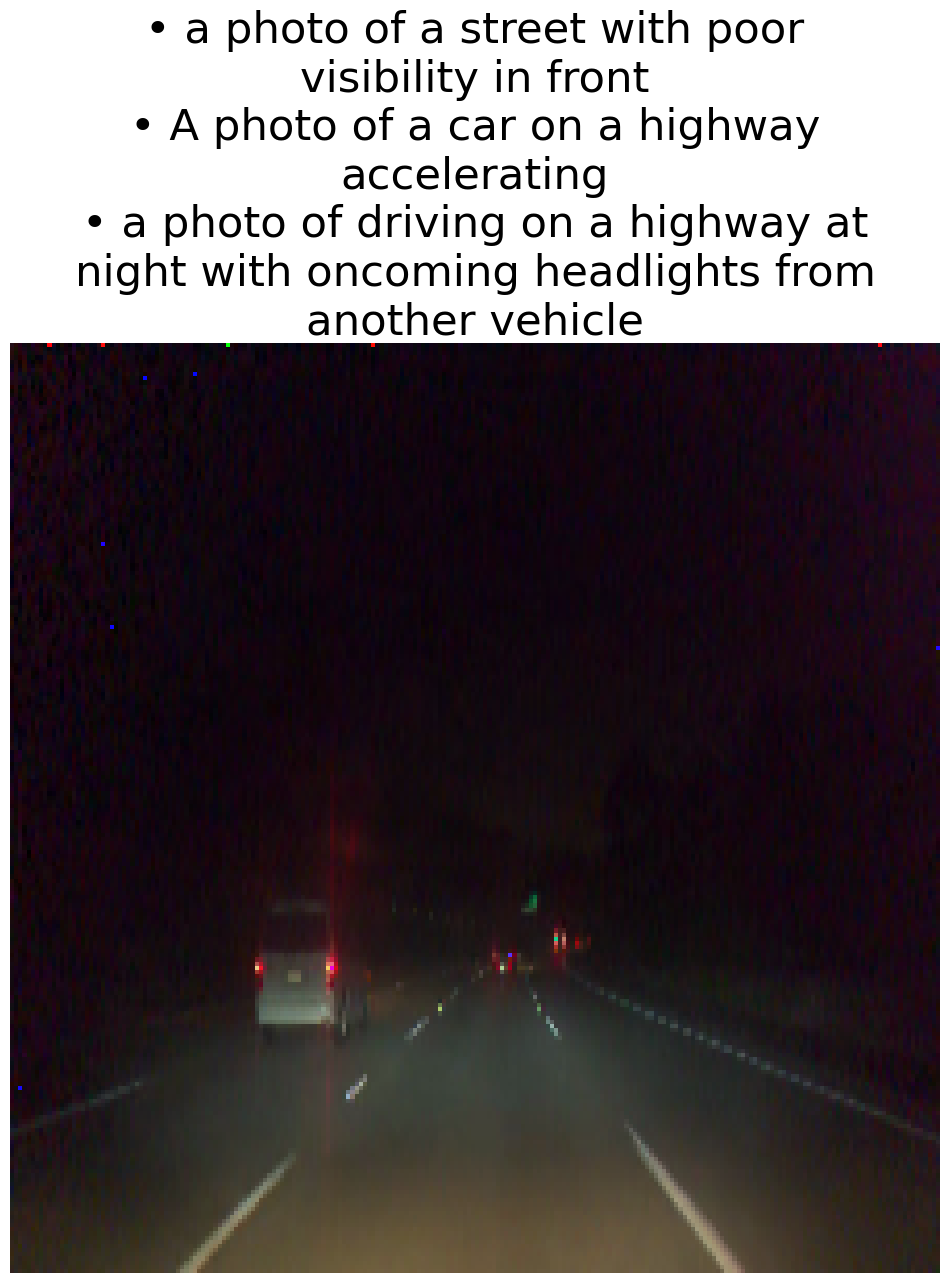

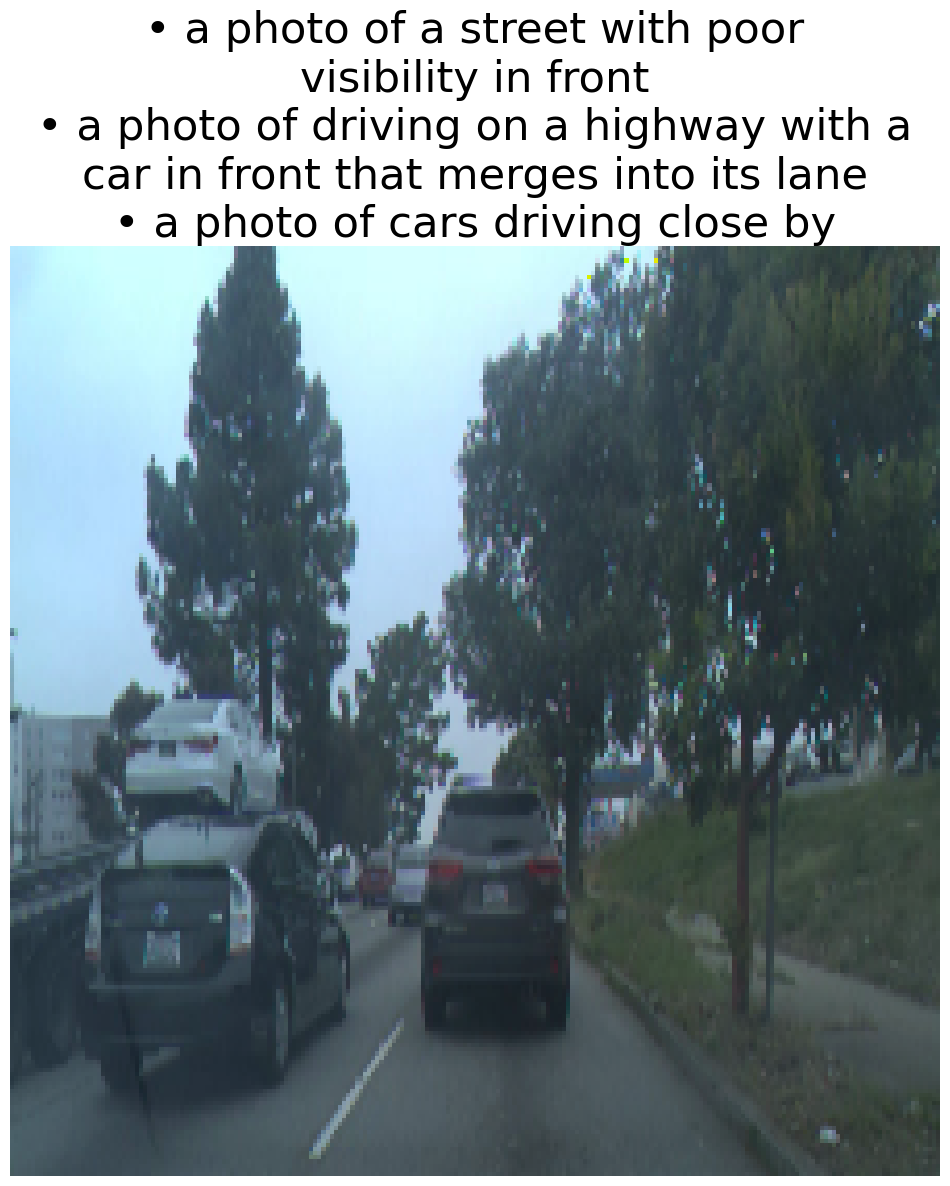

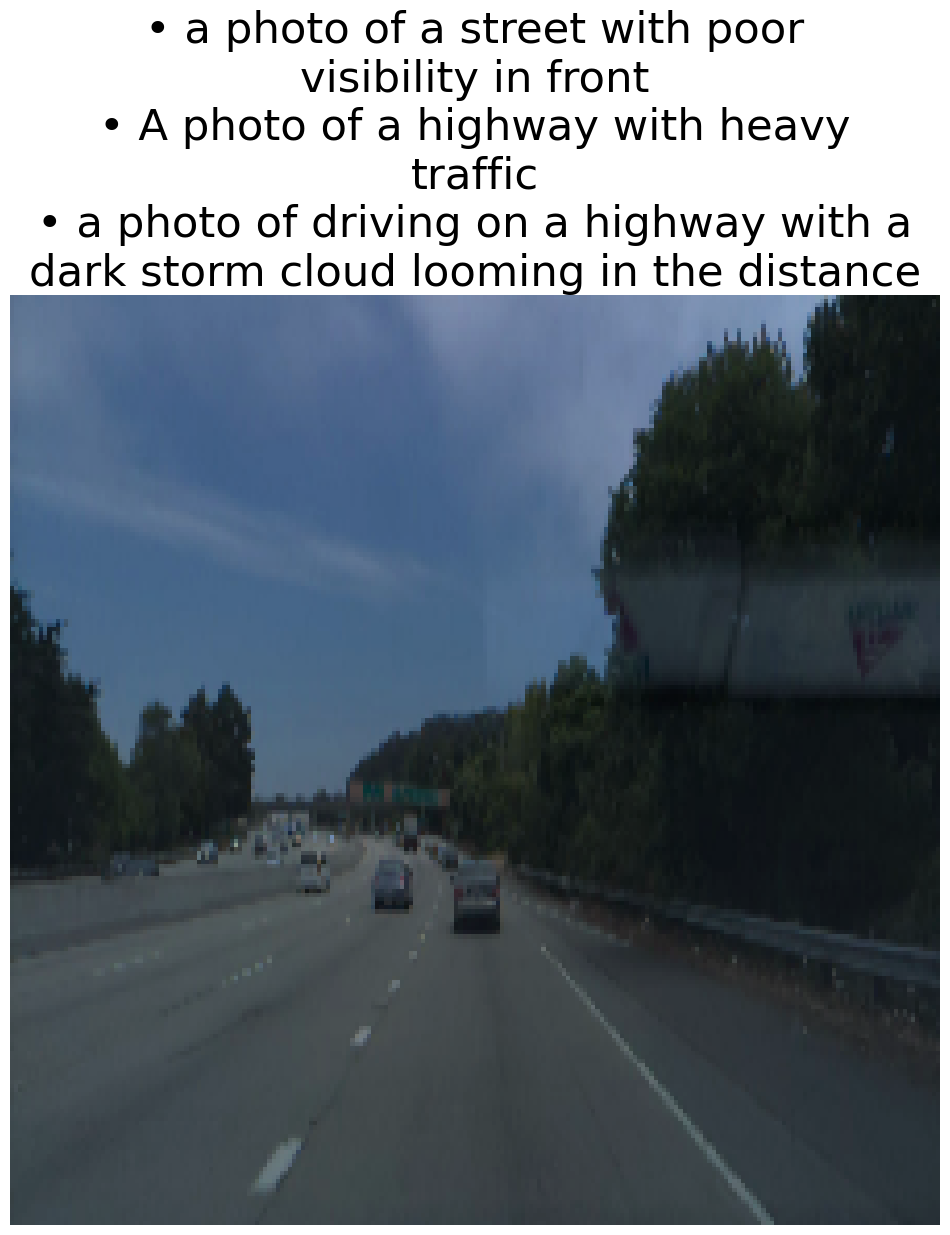

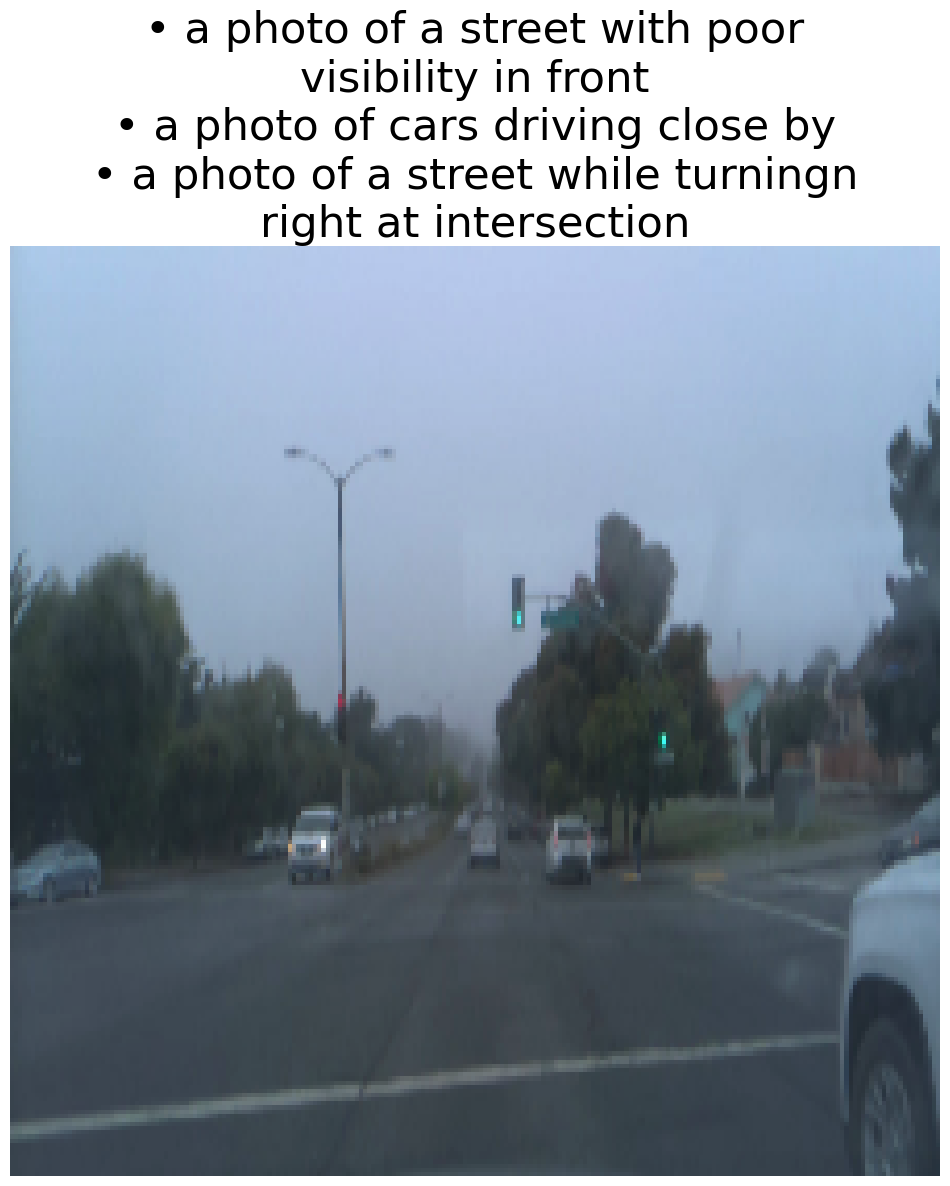

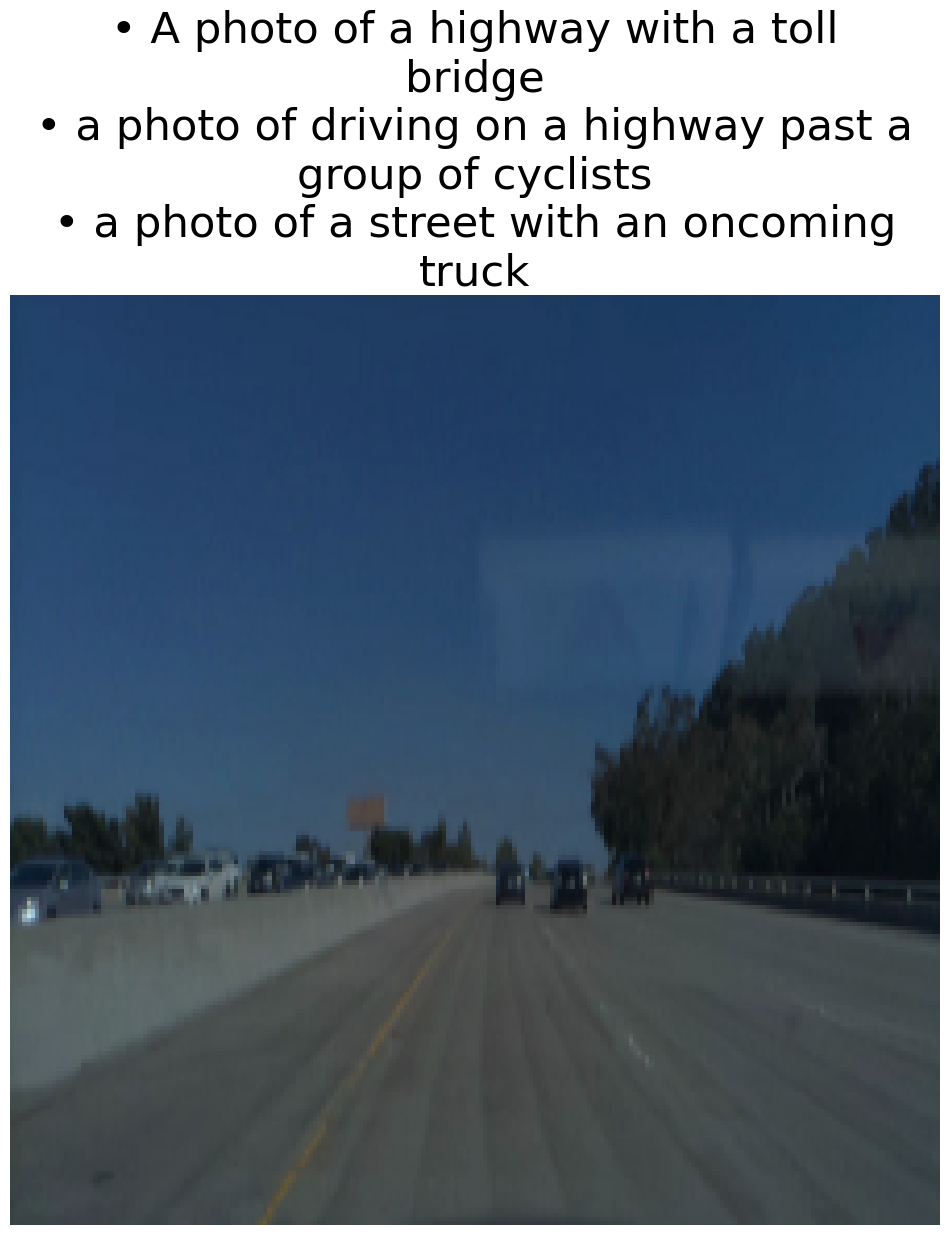

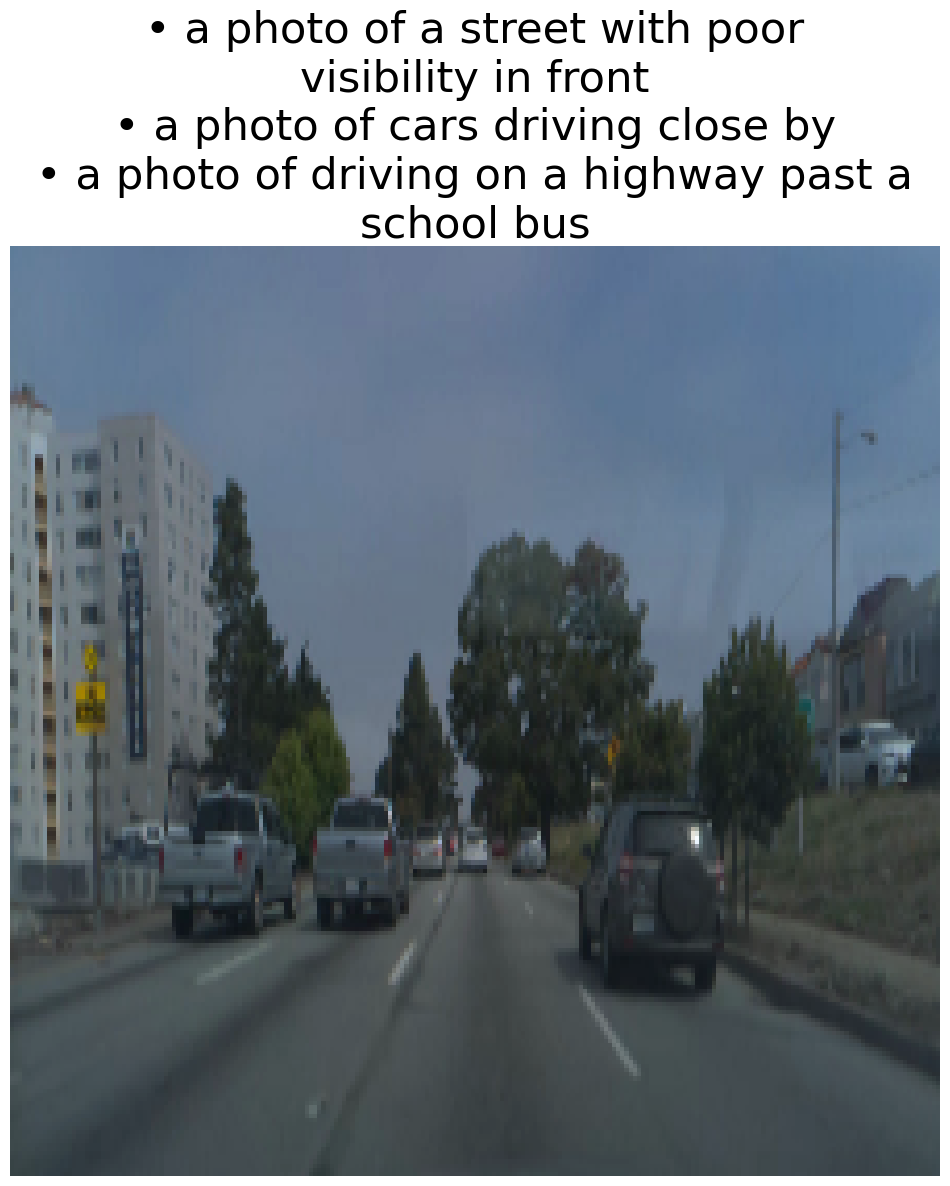

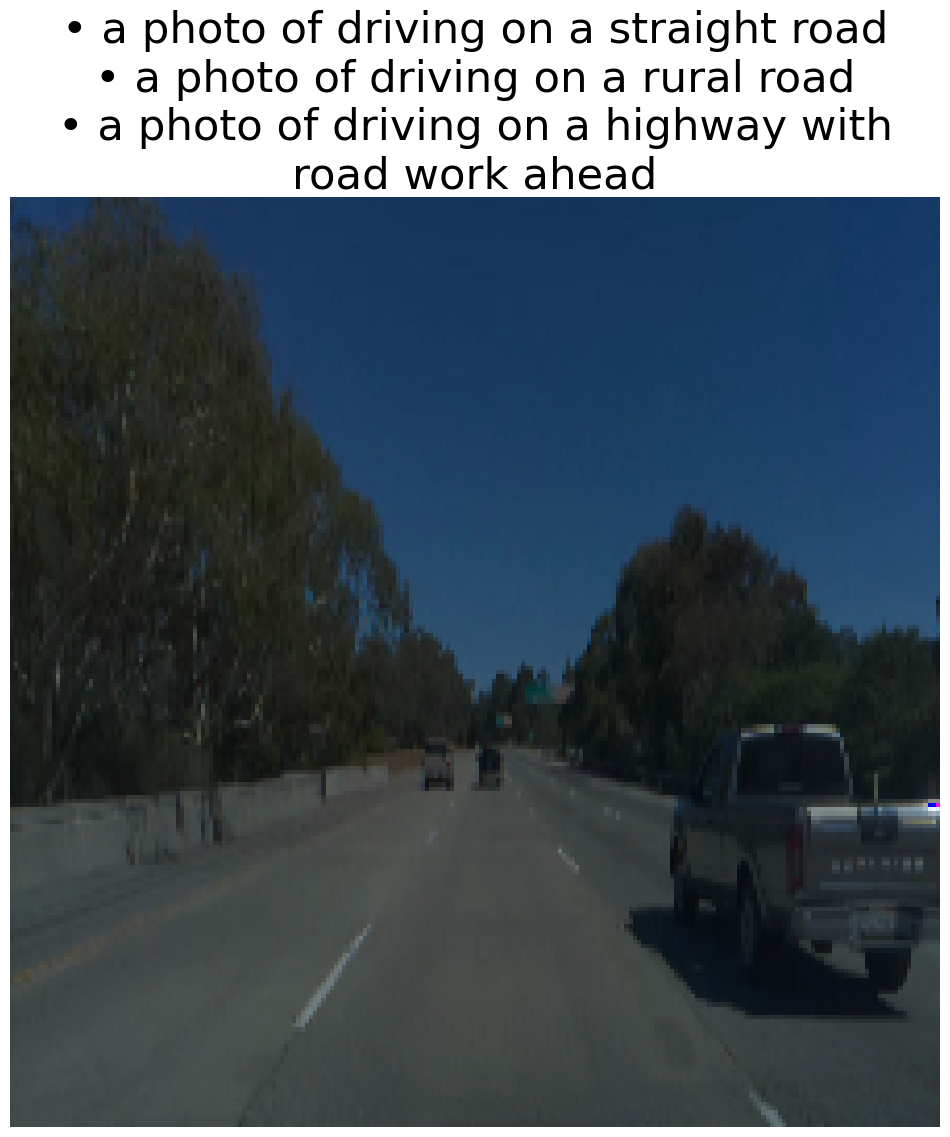

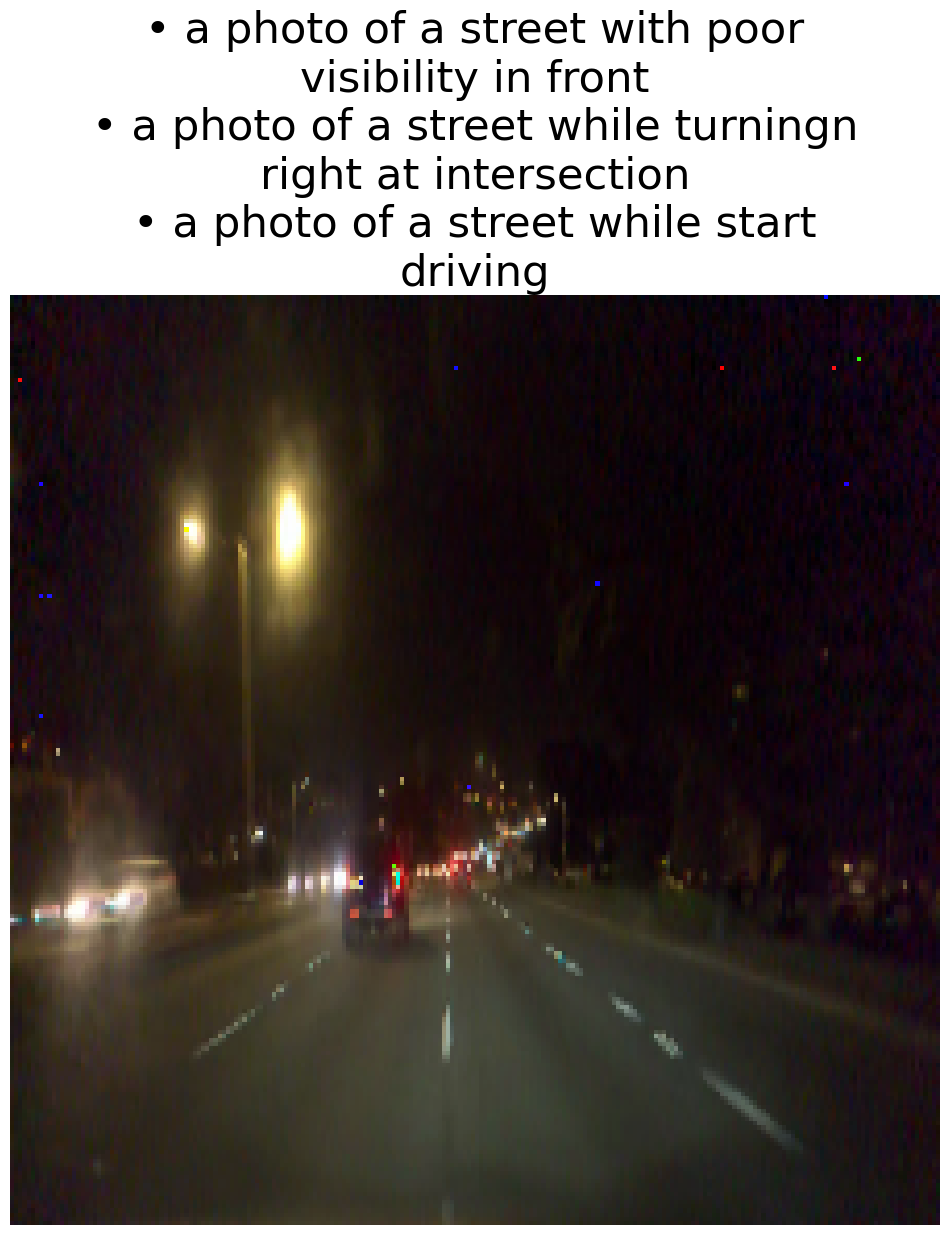

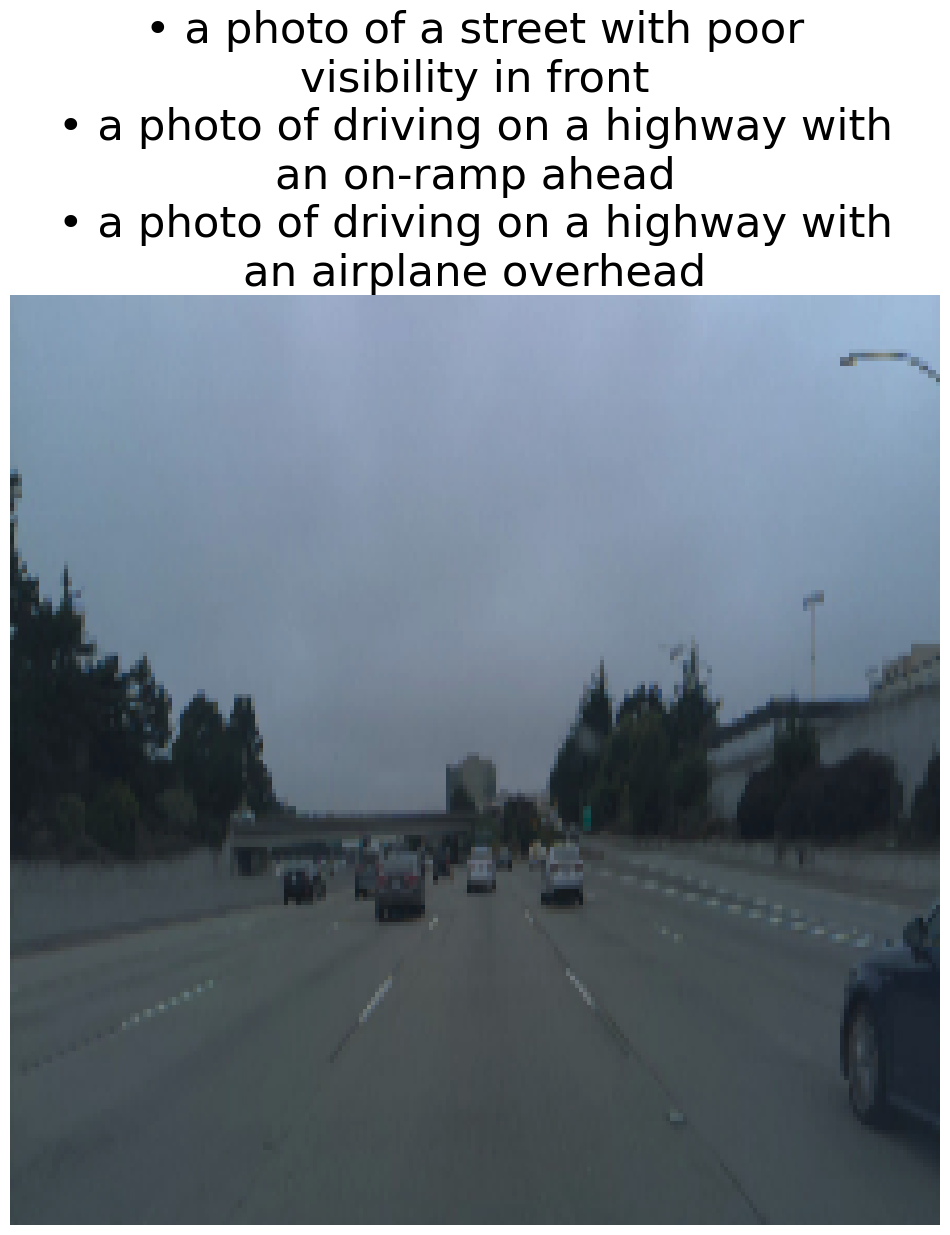

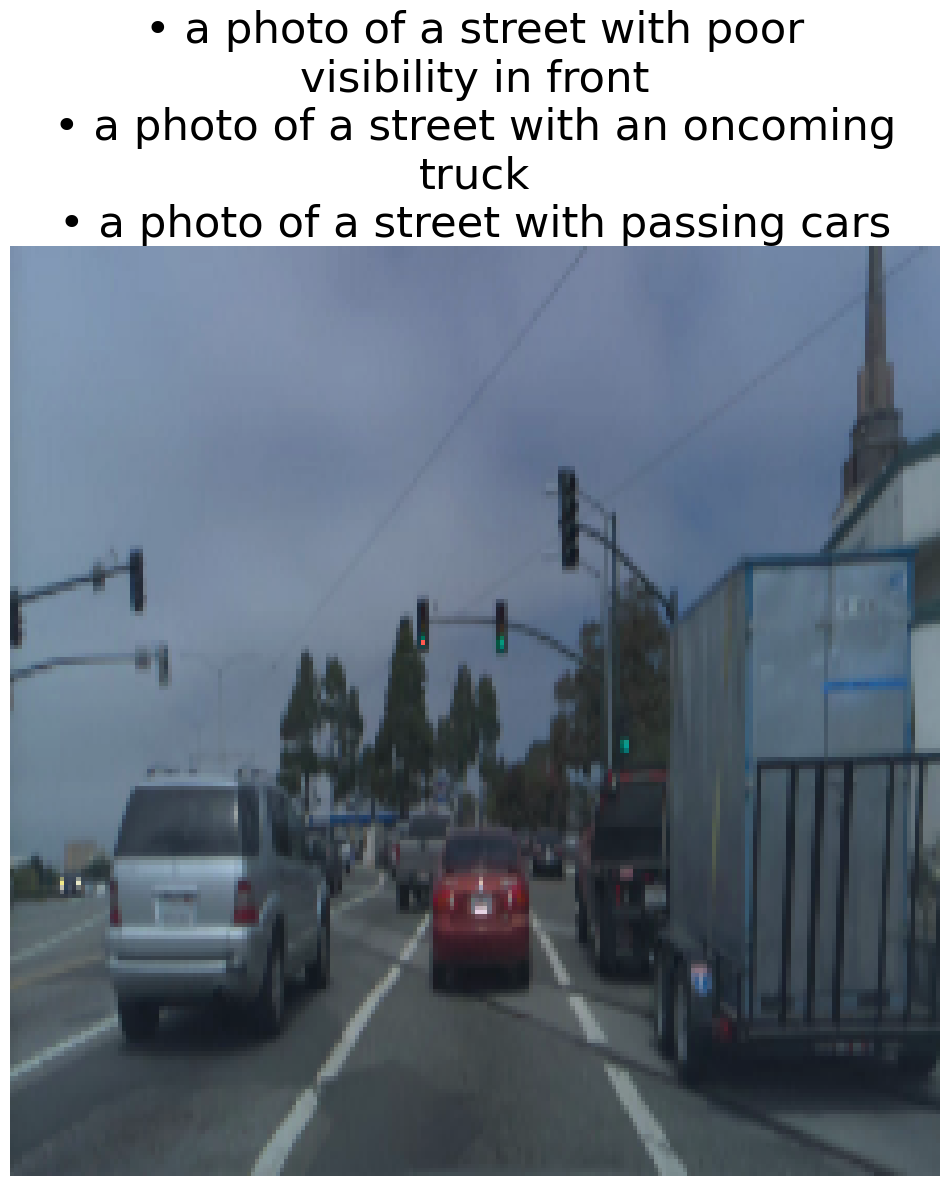

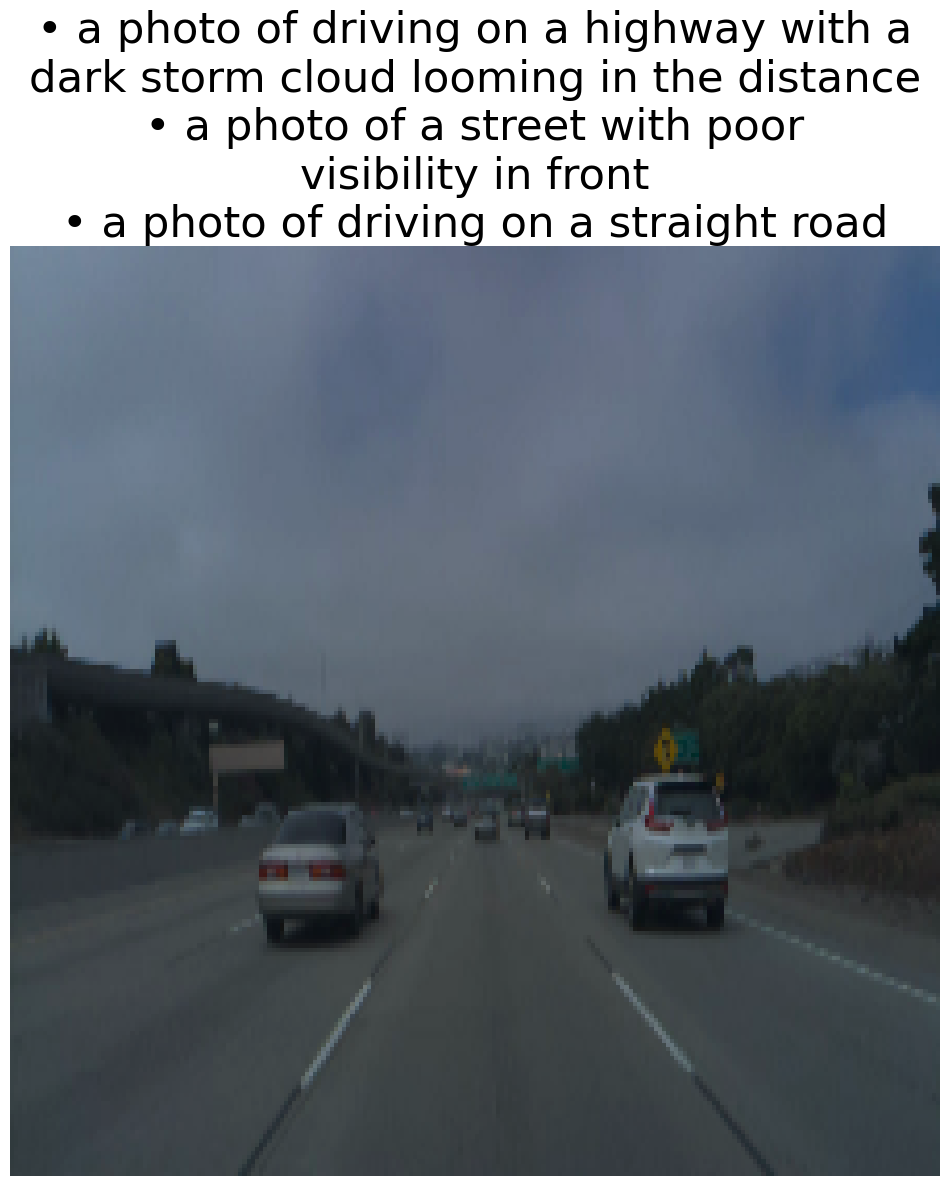

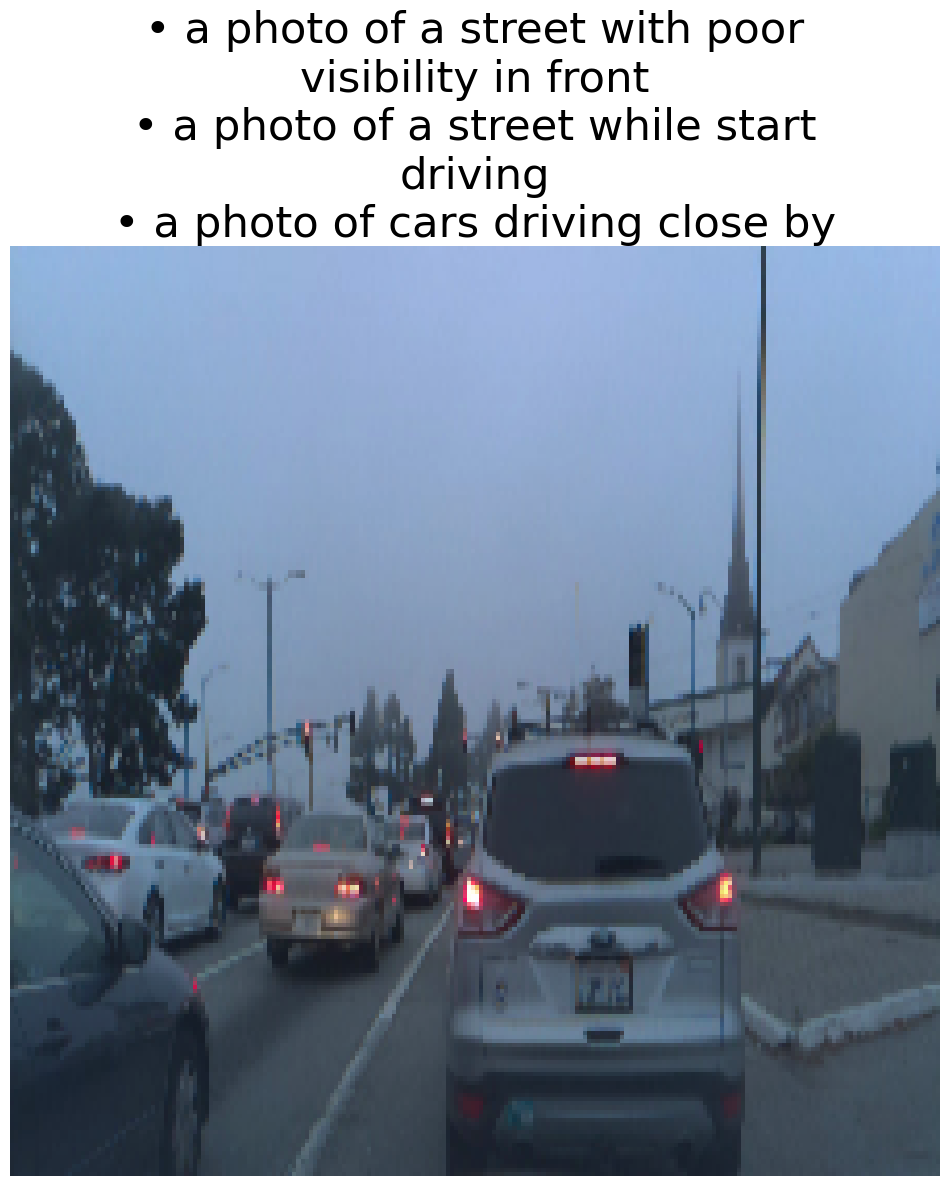

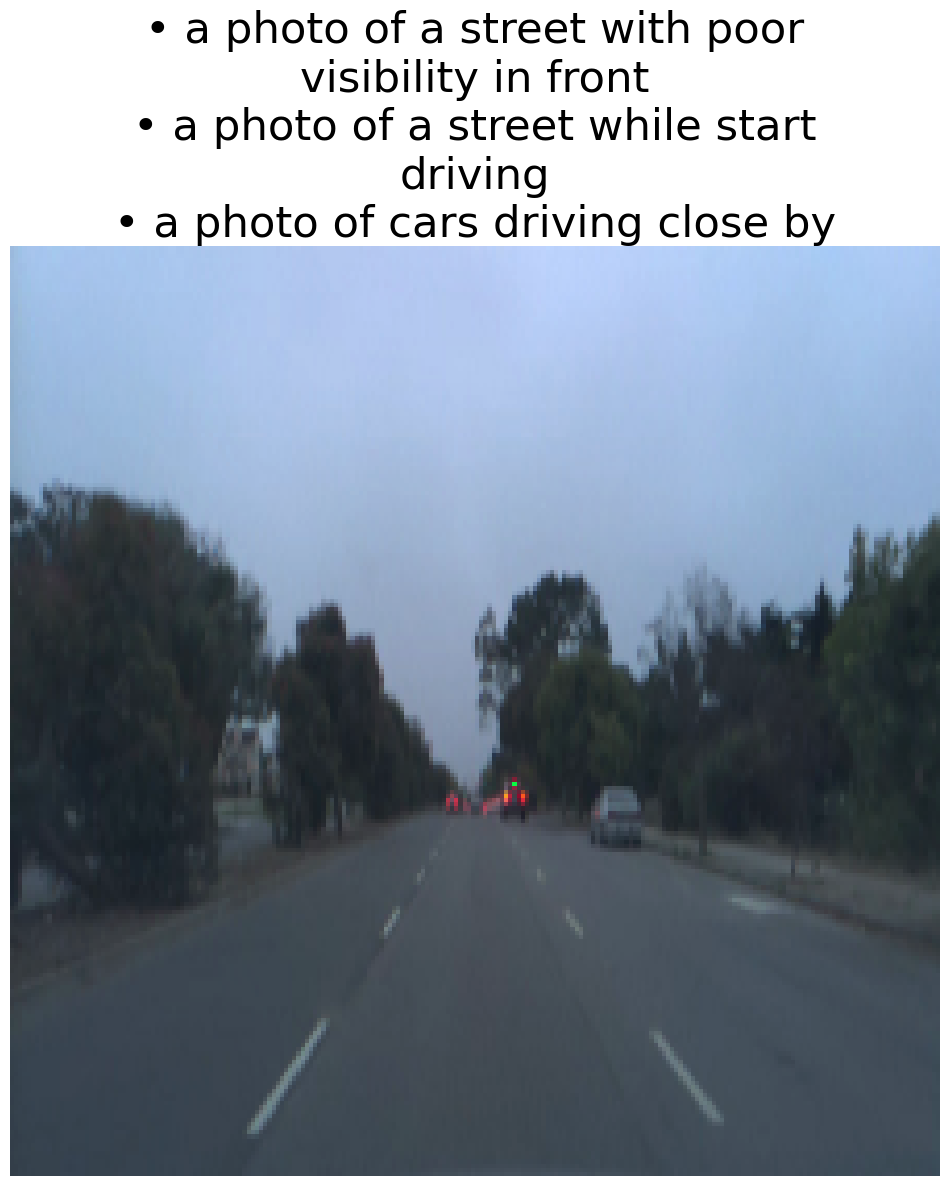

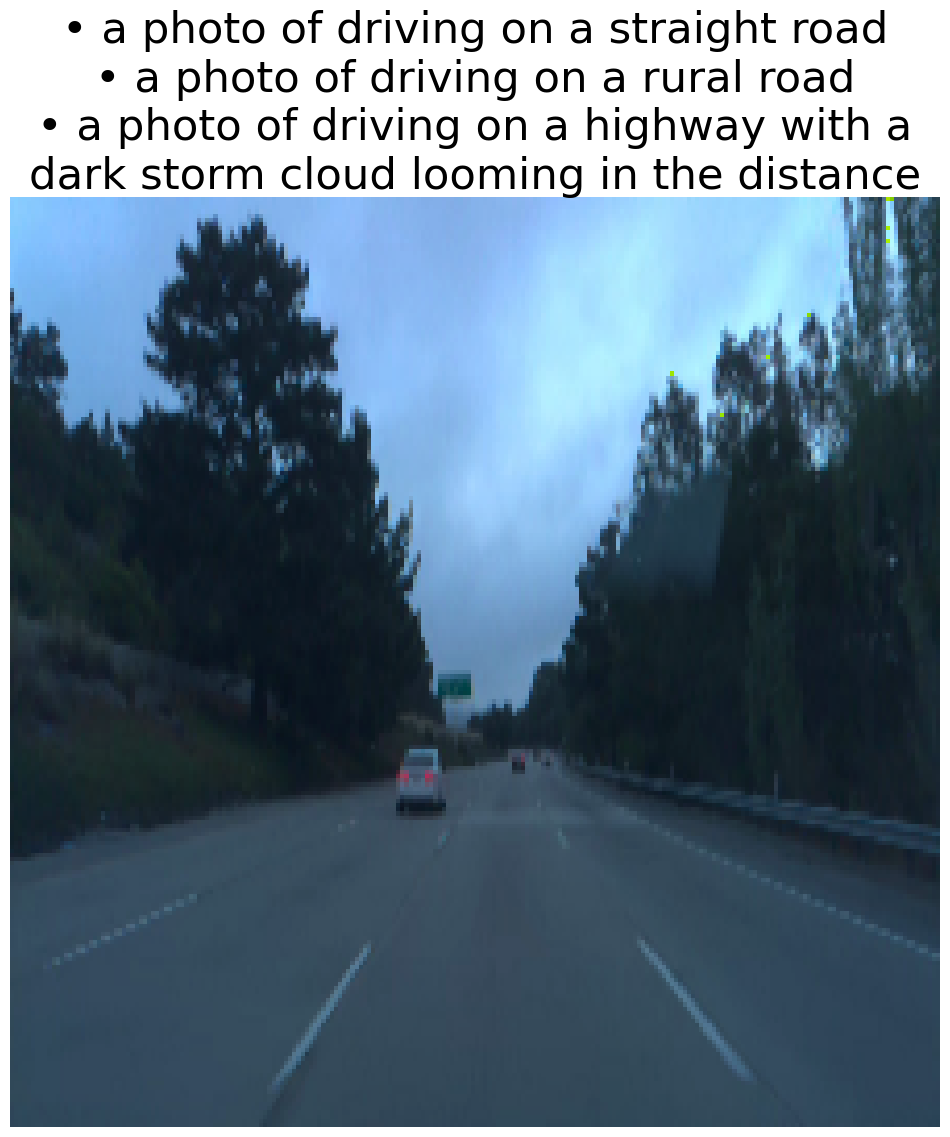

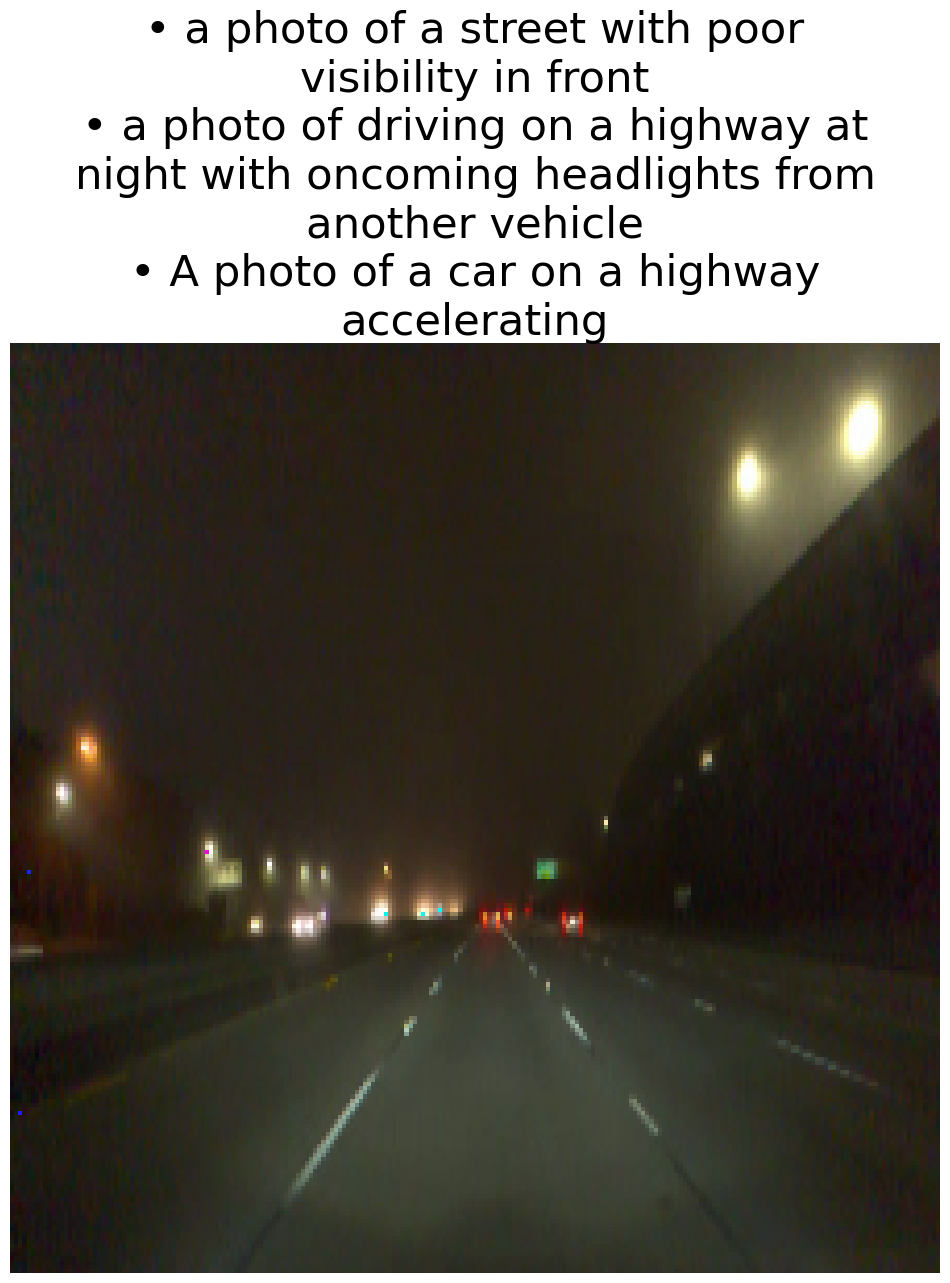

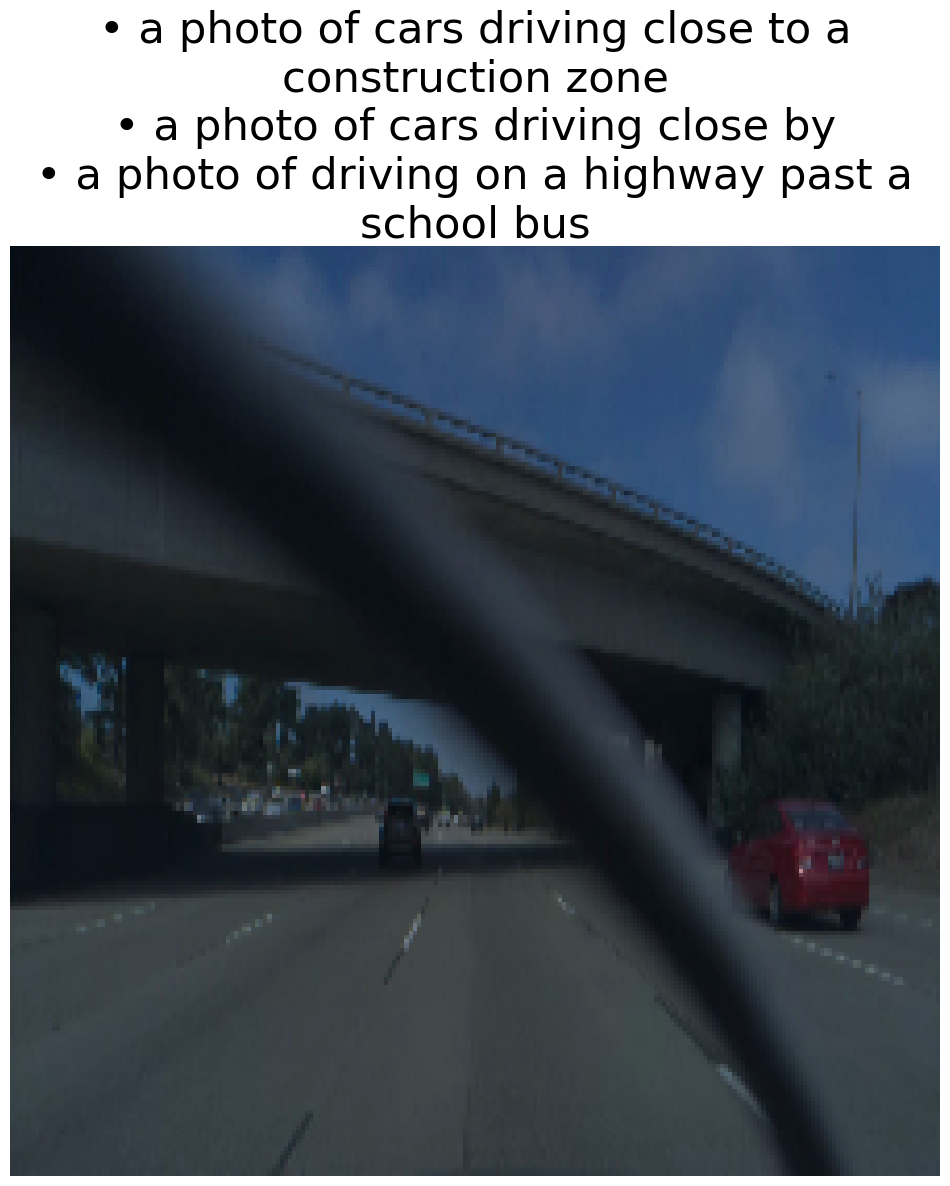

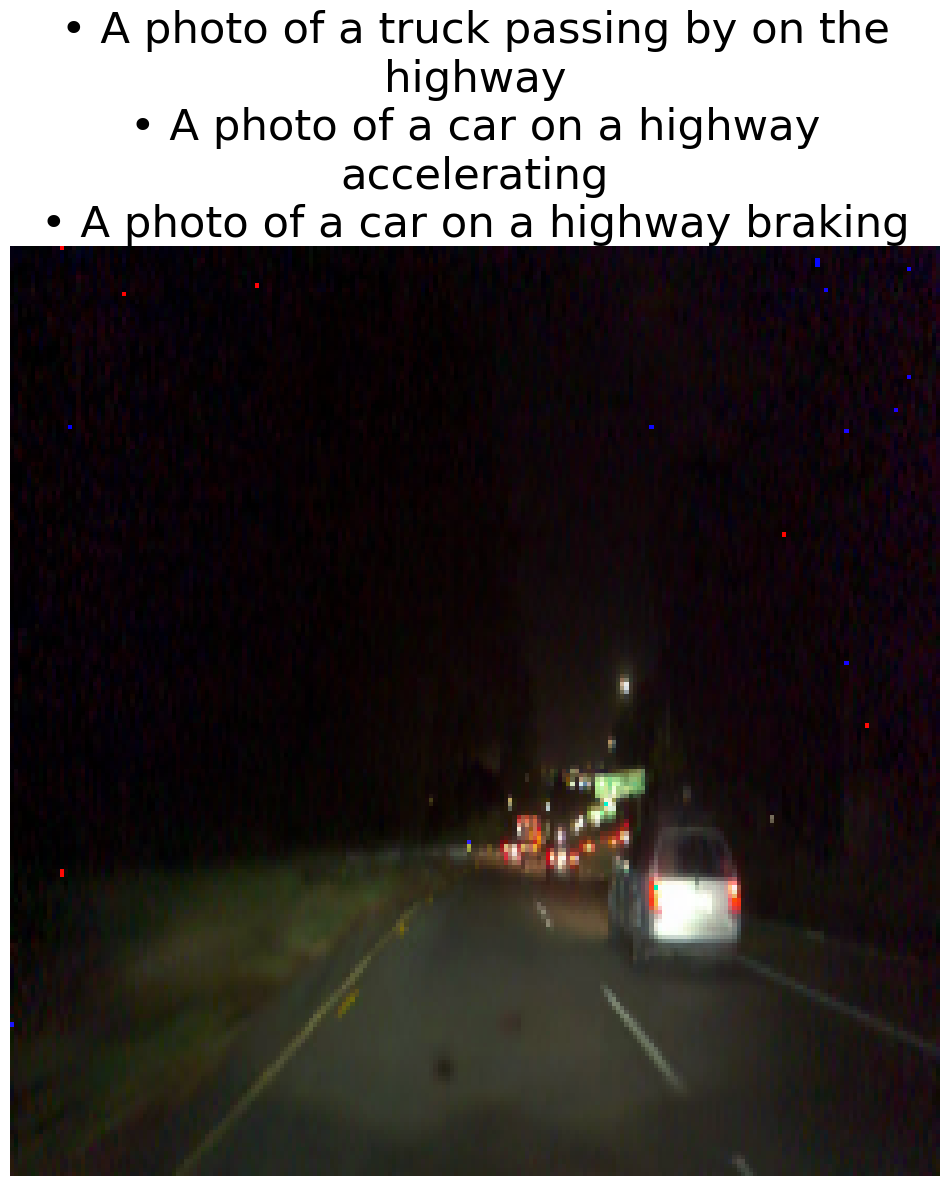

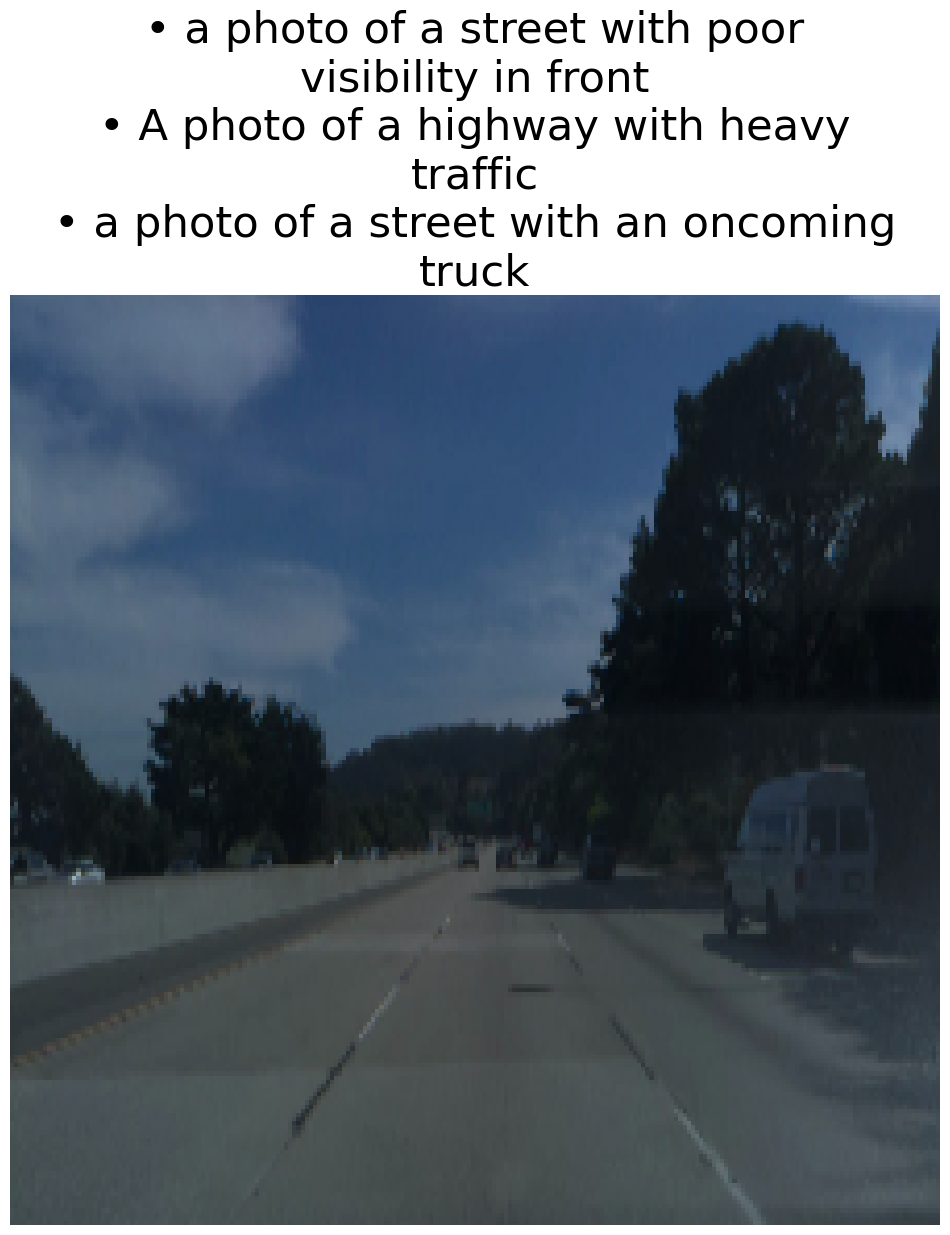

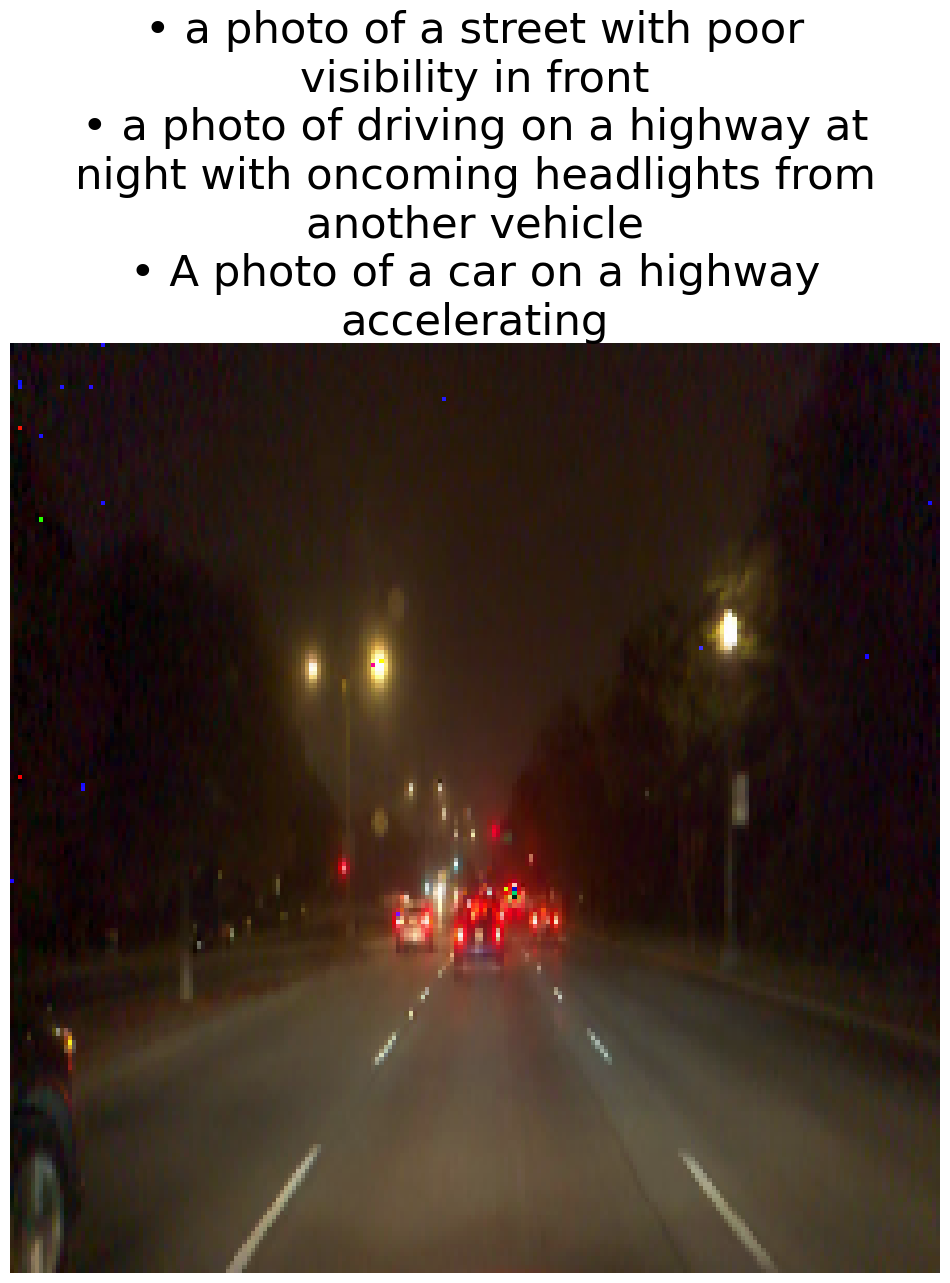

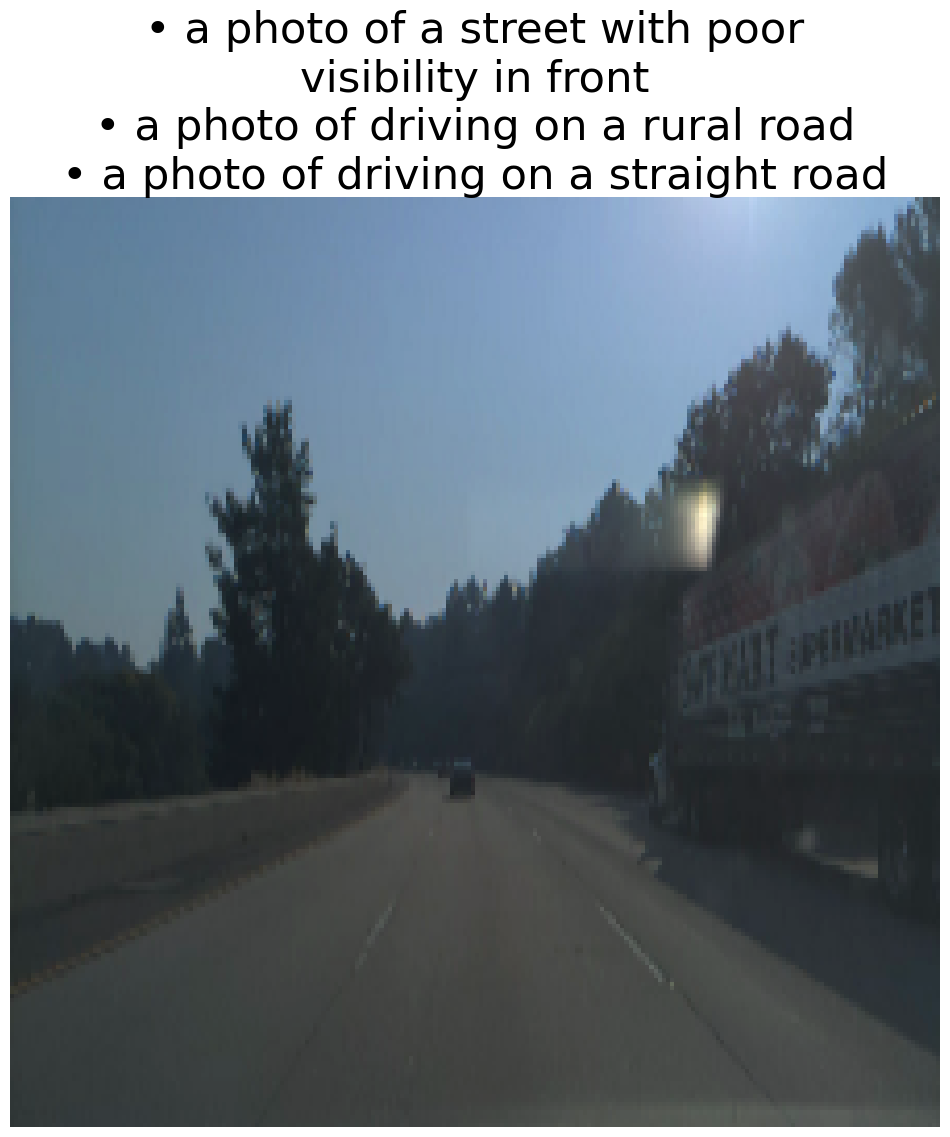

In [6]:
#for j, batch in enumerate(dataloader_nuscenes):
#    _, image_array,  vego, angle, distance, _, _, _, _, _ = batch
for j, batch in enumerate(dataloader_comma):
    image_array,  vego, angle, distance, g, s, l = batch
    img = image_array
    max_len = 240
    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    (logits, attns), concepts = model(img, angle, distance, vego)
    top5_indices_res = torch.tensor(concepts.squeeze()).topk(10)
    top5_indices = top5_indices_res.indices
    s = img.shape
    angle, distance, vego, logits, concepts = angle.to("cpu"), distance.to("cpu"), vego.to("cpu"), logits.detach().cpu().to("cpu"), concepts.detach().cpu().to("cpu")
    
    f = []
    inter = []
    img = img[:, 0:20]
    top5_indices = top5_indices[0:20]
    print(top5_indices.shape)
    
    
    #for i, elem0 in enumerate(top5_indices):
    #    #print(top5_indices_res.values[i])
    #    #print(elem0)
    #    inter = []
    for elem in top5_indices:
            l = elem.cpu().numpy().tolist()
            if 131 in l:
                l.remove(131)
            if 55 in l:
                l.remove(55)
            if 14 in l:
                l.remove(14)
            if 17 in l:
                l.remove(17)
            inter.extend(l)
            break
    count_dict = Counter(inter)
    # Get the top 5 most occurring numbers
    top_5 = count_dict.most_common(3)
    intermediate = []
    for a in top_5: 
            intermediate.append(scenarios[a[0]])
        #print(intermediate)
    #    f.append(intermediate)
    f = intermediate


    fig, axes = plt.subplots(1, 1, figsize=(12, 16))#,gridspec_kw= {'height_ratios': [20, 1]})

    plt_idx = 0
    for i, image in tqdm(enumerate(img[0])):
    
        #image_frame = (image).cpu().permute(1, 2, 0)
        image_frame = (image).cpu().permute(1, 2, 0)

        # Display the image frame
        axes.imshow((np.array(image_frame) * 255).astype(np.uint8))
        
        title = '\n'.join([split_string("\u2022 " + h) for h in f])
        axes.set_title(title)
        axes.set_aspect('equal')
        axes.set_xticks([])
        axes.set_yticks([])

        # Remove borders
        axes.spines['top'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.spines['right'].set_visible(False)

        plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/mturk/{i}.png")

    
    image_directory = '/home/jessica/personalized_driving_toyota/result_images/mturk/'

    # Set the output GIF file path
    output_path = lambda x: f'/home/jessica/personalized_driving_toyota/result_images/mturk/att/attention_comma_{j}_{x}.mp4'

    # Set the duration (in milliseconds) for each frame in the GIF
    frame_duration = 8000

    # Get a sorted list of image files in the directory
    image_files = sorted(glob.glob(f'{image_directory}/*.png'), key=extract_number)  # Adjust the file extension if necessary

    # Create a list to store the frames of the GIF
    frames = []

    # Iterate over each image file
    for image_file in image_files:
        # Open the image file
        image = Image.open(image_file)

        # Add the image to the list of frames
        frames.append(image)

    # Save the frames as a GIF
    #frames[0].save(output_path("gif"), format='GIF', append_images=frames[1:], save_all=True,
    #           duration=frame_duration, loop=0)
    imageio.mimsave(output_path("2"), frames, fps=1)
    #imageio.mimsave(output_path("1"), frames[40:56], fps=2)
    if j > 50: break

    directory = '/home/jessica/personalized_driving_toyota/result_images/mturk'
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            file_path = os.path.join(directory, filename)
            os.remove(file_path)

In [6]:
pip install imageio[ffmpeg]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
'''for j, batch in enumerate(dataloader_comma):
    _, image_array, vego, angle, distance, m_lens, i_lens, s_lens, a_lens, d_lens = batch
    #if (j != 4) and (j != 8) and (j != 5):
    #    continue
    img = image_array
    max_len = 240
    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    (logits, attns), concepts = model(img, angle, distance, vego)
    top5_indices = torch.tensor(concepts.squeeze()).topk(5).indices
    s = img.shape
    angle, distance, vego, logits, concepts = angle.to("cpu"), distance.to("cpu"), vego.to("cpu"), logits.detach().cpu().to("cpu"), concepts.detach().cpu().to("cpu")

    atten = attns[0][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_0 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_0 = moving_average(speed_graph_0, 10)

    atten = attns[1][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_1 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_1 = moving_average(speed_graph_1, 10)

    print('kkk')

    atten = attns[2][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_2 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_2 = moving_average(speed_graph_2, 10)
    speed_graph = speed_graph_0 + speed_graph_1 + speed_graph_2
    #speed_graph = moving_average(speed_graph, 5)
    
    f = []
    inter = []
    for i, elem0 in enumerate(top5_indices):
        inter = []
        for elem in top5_indices[max(i-5, 0):min(i+5,len(top5_indices))]:
            l = elem.cpu().numpy().tolist()
            if 131 in l:
                l.remove(131)
            inter.extend(l)
        count_dict = Counter(inter)
        # Get the top 5 most occurring numbers
        top_5 = count_dict.most_common(2)
        intermediate = []
        for a in top_5: 
            intermediate.append(scenarios[a[0]])
        f.append(intermediate)

    fig, axes = plt.subplots(2, 8, figsize=(8, 16),gridspec_kw= {'height_ratios': [20, 1]})

    plt_idx = 0
    print('ggg')
    for i, image in enumerate(img[0][10:-10]): 
        #arr = [0, 15, 30, 55, 90, 145, 155, 185]
        #if i not in arr: continue
    
        image_frame = unorm(image).cpu().permute(1, 2, 0)

        # Display the image frame
        axes[0].imshow((np.array(image_frame) * 255).astype(np.uint8))
        
        title = '\n'.join([split_string("\u2022 " + h) for h in f[i]])
        axes[0][plt_idx].set_title(title)
        axes[0][plt_idx].set_aspect('equal')
        axes[0][plt_idx].set_xticks([])
        axes[0][plt_idx].set_yticks([])

        # Remove borders
        axes[0][plt_idx].spines['top'].set_visible(False)
        axes[0][plt_idx].spines['bottom'].set_visible(False)
        axes[0][plt_idx].spines['left'].set_visible(False)
        axes[0][plt_idx].spines['right'].set_visible(False)

        # Plot the speed graph
        #axes[1][plt_idx].plot(speed_graph_0[10:-10], label='Attention Head 1', color='black')
        #axes[1][plt_idx].plot(speed_graph_1[10:-10], label='Attention Head 2', color='blue')
        '''axes[1][plt_idx].plot(speed_graph_2[10:-10], label='Attention Head 3', color='green')
        if i == 0:
            axes[1][plt_idx].set_ylabel('Attention Activation')
            axes[1][plt_idx].set_xlabel(' ')

        if i == 5: 
            axes[1][plt_idx].set_xlabel('Time Step')'''

        #axes[1][plt_idx].plot(i, speed_graph_0[10:-10][i], marker='o', markersize=10, color='black')
        #axes[1][plt_idx].plot(i, speed_graph_1[10:-10][i], marker='o', markersize=10, color='blue')
        '''axes[1][plt_idx].plot(i, speed_graph_2[10:-10][i], marker='o', markersize=30, color='green')
        axes[1][plt_idx].spines['top'].set_visible(False)
        axes[1][plt_idx].spines['right'].set_visible(False)'''

        plt_idx +=1


        # Adjust the plot layout if necessary

        #arr = [0, 15, 20, 30, 55, 90, 145, 155, 185, 215]
        #if i in arr: 
        plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/mturk/{j}_{i}.pdf")
        #    plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/attention_2/{j}_{i}.png")
        #    plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/attention/{i}.png")
        #   plt_individual.append(fig)
        #plt.clf()
        #plt.close()
    #fig.subplots_adjust(wspace=0.15, hspace=0.01)
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85)
    #plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/mturk/attention_3/{j}.pdf")
    #plt.show()
    
    image_directory = '/home/jessica/personalized_driving_toyota/result_images/mturk/'

    # Set the output GIF file path
    output_path = lambda x: f'/home/jessica/personalized_driving_toyota/result_images/mturk/attention_comma_{j}.{x}'

    # Set the duration (in milliseconds) for each frame in the GIF
    frame_duration = 500

    # Get a sorted list of image files in the directory
    image_files = sorted(glob.glob(f'{image_directory}/*.png'), key=extract_number)  # Adjust the file extension if necessary

    # Create a list to store the frames of the GIF
    frames = []

    # Iterate over each image file
    for image_file in image_files:
        # Open the image file
        image = Image.open(image_file)

        # Add the image to the list of frames
        frames.append(image)

    # Save the frames as a GIF
    frames[0].save(output_path("gif"), format='GIF', append_images=frames[1:], save_all=True,
                duration=frame_duration, loop=0)
    imageio.mimsave(output_path("mp4"), frames, fps=30)  # Adjust the fps as needed
    normalized_weights = atten#np.array(attention_weights) / np.sum(attention_weights)

    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.pcolormesh(alignment_array[0:70, :], cmap='hot')
    # Add colorbar
    cbar = plt.colorbar(heatmap)

    # Add labels and title
    ax.set_xlabel('Sequence Position')
    ax.set_ylabel('Window')
    ax.set_title('Longformer Sliding Chunk Attention')

    # Show the plot
    #plt.savefig(f"/home/jessica/personalized_driving_toyota/attention_vis{j}.pdf")
    plt.close()
    break'''

    